
-----


# Ames Housing Sale Price Analysis

---

## Python 3 Notebook


### Regression and Classification with the Ames Housing Data

Note: Some cells in the classification exercise (RFE and Lasso feature selection in particular) take > 1 minute to run.

---

### Situation:

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [295]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrix, dmatrices

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# Introduction

## EDA Discussion

Prior to commencing the data EDA I reviewed the Ames Housing data article to extract key information about the dataset to help with cleaning:

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

- "80 variables remained that were directly related to property sales. Of which:
- 20 continuous variables relate to various area dimensions for each observation. The large number of continuous variables in this data set should give students many opportunities to differentiate themselves as they consider various methods of using and combining the variables.
- 14 discrete variables typically quantify the number of items occurring within the house. Most are specifically focused on the number of kitchens, bedrooms, and bathrooms.
- There are a large number of categorical variables (23 nominal, 23 ordinal) associated with this data set. They range from 2 to 28 classes with the smallest being STREET (gravel or paved) and the largest being NEIGHBORHOOD (areas within the Ames city limits). 
- Recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students."

## Variable Assumptions:
Some of the more subjective assumptions I have decided upon for the fixed/changeable variables are:
- Year Rem/Add is assumed to be fixed
- All variables that relate to the basement being finished/unfinished are assumed to be renovateable (i.e.: unfinished basement sqft can be increased if necessary to improve price)
- Garage, although external is assumed to be a permanent feature of the main property

I will now review the data, filter as instructed above and then engineer features and produce a model to predict the SalePrice.


### Data Review

In [296]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [297]:
house.shape

(1460, 81)

In [298]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [299]:
# Reading in the dictionary that I created externally. This outlines lists the field in the data, their type, description 
# and whether they are Fixed or Renovate-able/Changeable. This will be used as a reference for the two models

data_dict = pd.read_csv('./data_description_variable_definition.csv')
print (data_dict)

         Variable    DataType  \
0          Order     Discrete   
1            PID      Nominal   
2      MSSubClass     Nominal   
3        MSZoning     Nominal   
4     LotFrontage  Continuous   
5         LotArea  Continuous   
6          Street     Nominal   
7           Alley     Nominal   
8        LotShape     Ordinal   
9     LandContour     Nominal   
10      Utilities     Ordinal   
11      LotConfig     Nominal   
12      LandSlope     Ordinal   
13   Neighborhood     Nominal   
14     Condition1     Nominal   
15     Condition2     Nominal   
16       BldgType     Nominal   
17     HouseStyle     Nominal   
18    OverallQual     Ordinal   
19    OverallCond     Ordinal   
20      YearBuilt    Discrete   
21   YearRemodAdd    Discrete   
22      RoofStyle     Nominal   
23       RoofMatl     Nominal   
24    Exterior1st     Nominal   
25    Exterior2nd     Nominal   
26     MasVnrType     Nominal   
27     MasVnrArea  Continuous   
28      ExterQual     Ordinal   
29      Ex

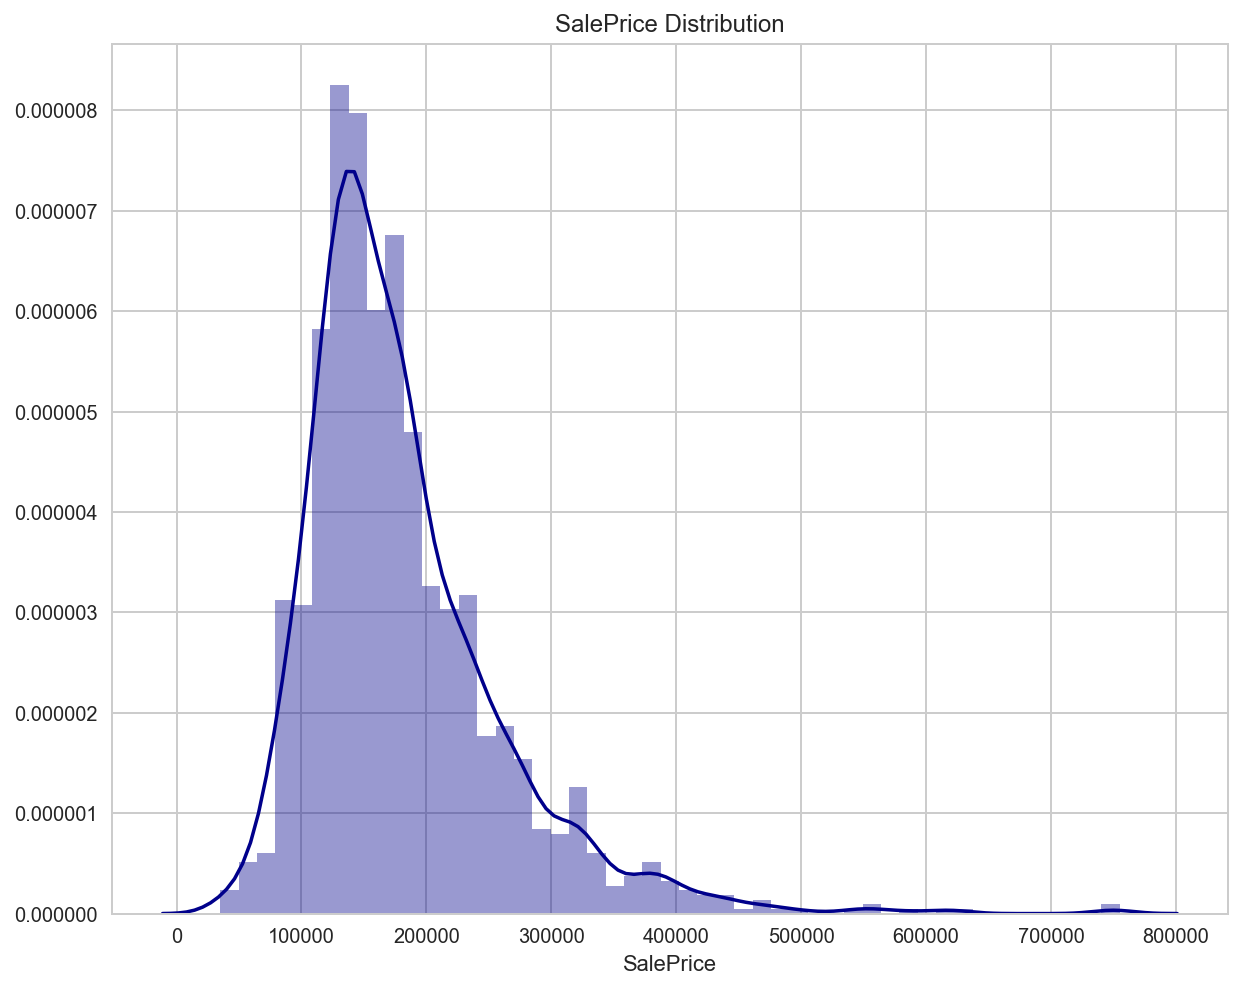

In [300]:
# Plot the distribution of the target variable - a positively skewed histogram with fairly high kurtosis
plt.figure(figsize=[10,8])
sns.distplot(house['SalePrice'], color='darkblue')
plt.title("SalePrice Distribution")
plt.show()

In [301]:
# Removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.
house = house[house["GrLivArea"] <= 4000]
house.shape

(1456, 81)

### Data Cleaning

In [302]:
print (house.isnull().sum().sort_values(ascending=False).head(20))
# There are 19 columns with null values. Some columns have many nulls so dropna is not appropriate as it would 
# remove too many records. Due to the mixture of variable types I will now run through each 
# and decide how best to treat the nulls.

PoolQC          1451
MiscFeature     1402
Alley           1365
Fence           1176
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64


In [303]:
# Replacing Nulls

# The following variables are all categorical in the documentation and state that where there is no value, 
# there is no feature (NA), so it will be replace with 'NA'.
for col in ['PoolQC','FireplaceQu','GarageCond','GarageQual','BsmtCond','BsmtQual','Fence','Alley','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageFinish','GarageType']:
    house[col] = house[col].fillna('NA')
    
# Both LotFrontage and MasVnrArea are continuous numeric columns so their null values will be set to 0.
for col in ['LotFrontage','MasVnrArea']:
    house[col] = house[col].fillna(0)  
    
# MasVnrType: If Masonry veneer type is null then assumed to be no veneer and will be coded as 'None'
house['MasVnrType'] = house['MasVnrType'].fillna('None')

# Electrical is a categorical string variable so nulls with be set to
house['Electrical'] = house['Electrical'].fillna('NA')

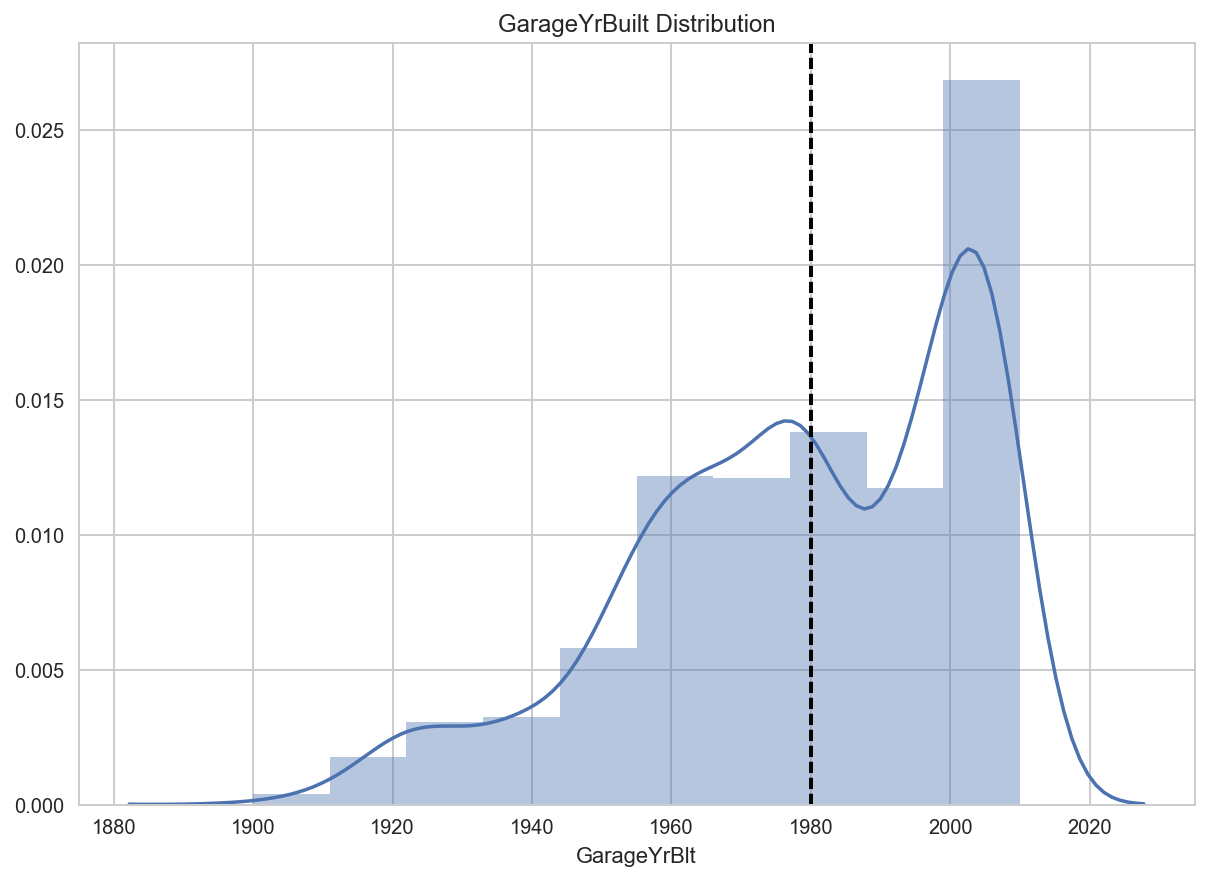

In [304]:
# The garage null values will be set to the median. The below distplot shows the effect of this:

GarageYrBltMedian = house.GarageYrBlt.median()
house['GarageYrBlt'] = house['GarageYrBlt'].fillna(GarageYrBltMedian)

# Plot distribution
plt.figure(figsize=[10,7])
sns.distplot(house['GarageYrBlt'],bins=10)
plt.title('GarageYrBuilt Distribution')
plt.axvline(GarageYrBltMedian, color='black', linestyle='--', lw=2)
plt.show()

# The median replacement does not dramatically change the distribution of the predictor; the mode group according to the histogram is >2000)

In [305]:
# MiscFeature variable

# To investigate the effect of all miscellaneous features, I will create a set of dummy variables

house_miscfeature = pd.get_dummies(house['MiscFeature'])

# Join the dummy variables to the main dataframe:

house = pd.concat([house, house_miscfeature], axis=1)

# Drop MiscFeature column and one of the MiscFeature categories ('other'):

house = house.drop('MiscFeature', 1)
house = house.drop('Othr', 1) 

In [306]:
# Check all nulls have been removed:

print (house.isnull().sum().sort_values(ascending=False).head(1))

TenC    0
dtype: int64


In [307]:
# Create residential only property dataframe:

# Filter house dataframe to only contain residential zoning IDs
Residential = ['FV', 'RH', 'RL', 'RM']

house = house.loc[house['MSZoning'].isin(Residential)]

# Check new dataframe shape

print(house.groupby(['MSZoning'])['MSZoning'].count())
print(house.shape)

MSZoning
FV      65
RH      16
RL    1147
RM     218
Name: MSZoning, dtype: int64
(1446, 83)


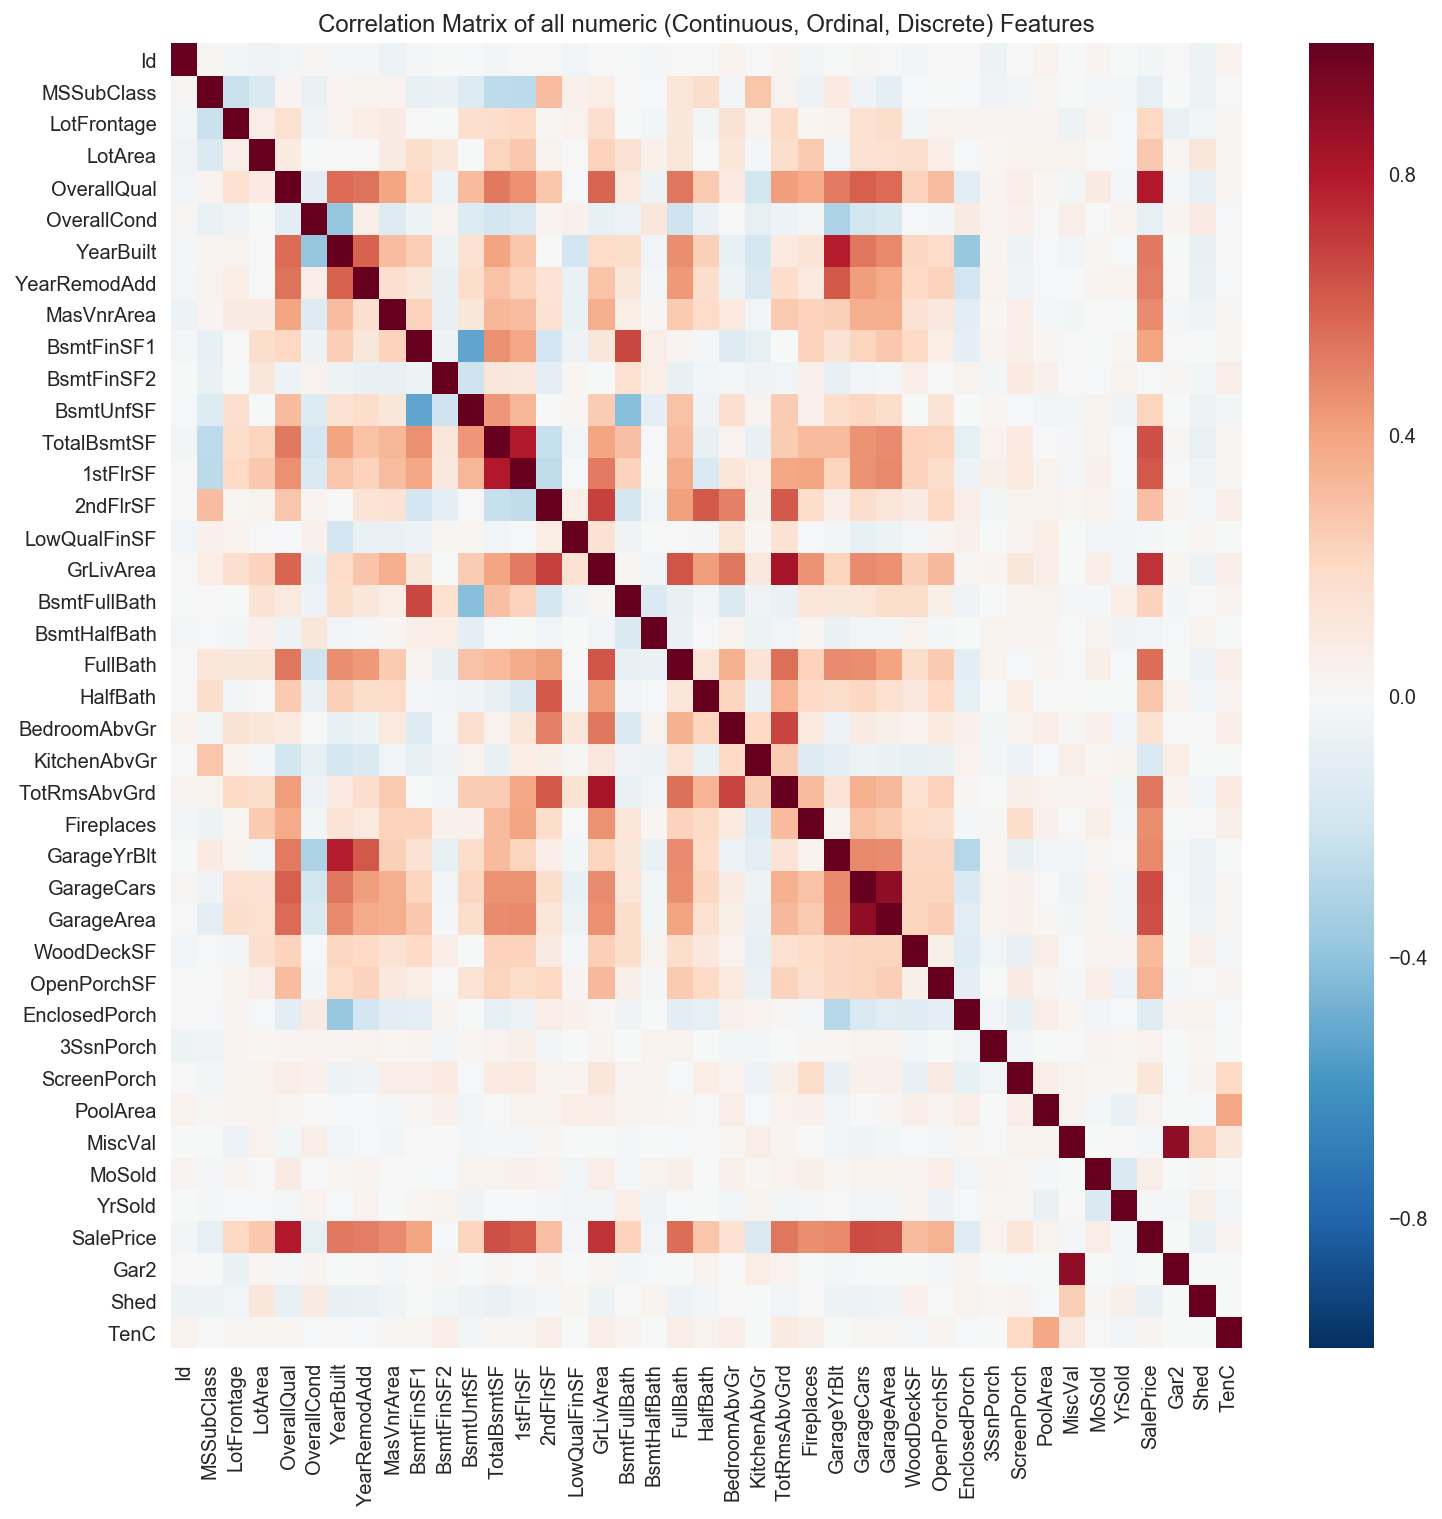

In [308]:
# Correlation Matrix
corr = house.corr()
plt.figure(figsize=[12,12])
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix of all numeric (Continuous, Ordinal, Discrete) Features')

In [309]:
# Specifically I want to investigate correlation of all numeric variables against the target SalePrice

corr = house.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.798954
GrLivArea        0.720743
GarageCars       0.651195
TotalBsmtSF      0.645274
GarageArea       0.643874
1stFlrSF         0.622735
FullBath         0.554926
TotRmsAbvGrd     0.537203
YearBuilt        0.530009
YearRemodAdd     0.515539
GarageYrBlt      0.478614
MasVnrArea       0.472112
Fireplaces       0.463039
BsmtFinSF1       0.393968
OpenPorchSF      0.345063
WoodDeckSF       0.318834
2ndFlrSF         0.297647
HalfBath         0.279647
LotArea          0.270918
BsmtFullBath     0.232666
BsmtUnfSF        0.222500
LotFrontage      0.206643
BedroomAbvGr     0.154066
ScreenPorch      0.117454
MoSold           0.062658
3SsnPorch        0.046642
PoolArea         0.032499
TenC             0.023805
Gar2            -0.004937
BsmtFinSF2      -0.011742
LowQualFinSF    -0.018267
YrSold          -0.020001
MiscVal         -0.020962
Id              -0.030014
BsmtHalfBath    -0.037788
Shed            -0.062812
MSSubClass      -0.091525
OverallCond 

## Correlations and Predictor Investigation

#### Top 10 SalePrice correlation coefficients:

1. TotalSF:          0.825066

2. OverallQual:      0.800858

3. GrLivArea:        0.720516

4. GarageCars:       0.649256

5. TotalBsmtSF:      0.646584

6. GarageArea:       0.636964

7. 1stFlrSF:         0.625235

8. FullBath:         0.559048

9. TotRmsAbvGrd:     0.537462

10. YearBuilt        0.535279

### Some predictors I will investigate further:

After my intital data review I have identified the following questions to investigate further prior to model building:
1. There is moderate correlation with SalePrice for TotalBsmtSF and 1stFlrSF but not for 2ndFlSF - does a combined 'Total House square footage' provide a stronger correlation?
- Moderate correlation for Year Built and Renovated Year. If we take the most recent of the two (i.e.: the max) does this indicate a stronger correlation?
- Does combining full and half bathroom numbers create a higher correlated variable?
- The correlation between the number of kitchens (KitchenAbvGr) and bedrooms (BedroomAbvGr) with the sale price is surprisingly low. Does the ratio of these room types to the total number of rooms have a stronger relationship?
- Is there a correlation between Lot Shape and Land Slope and the SalePrice? I will need to create two new numeric features to investigate this.
- Are sale prices in certain suburbs higher than others?

#### 1. Square Foot Investigation

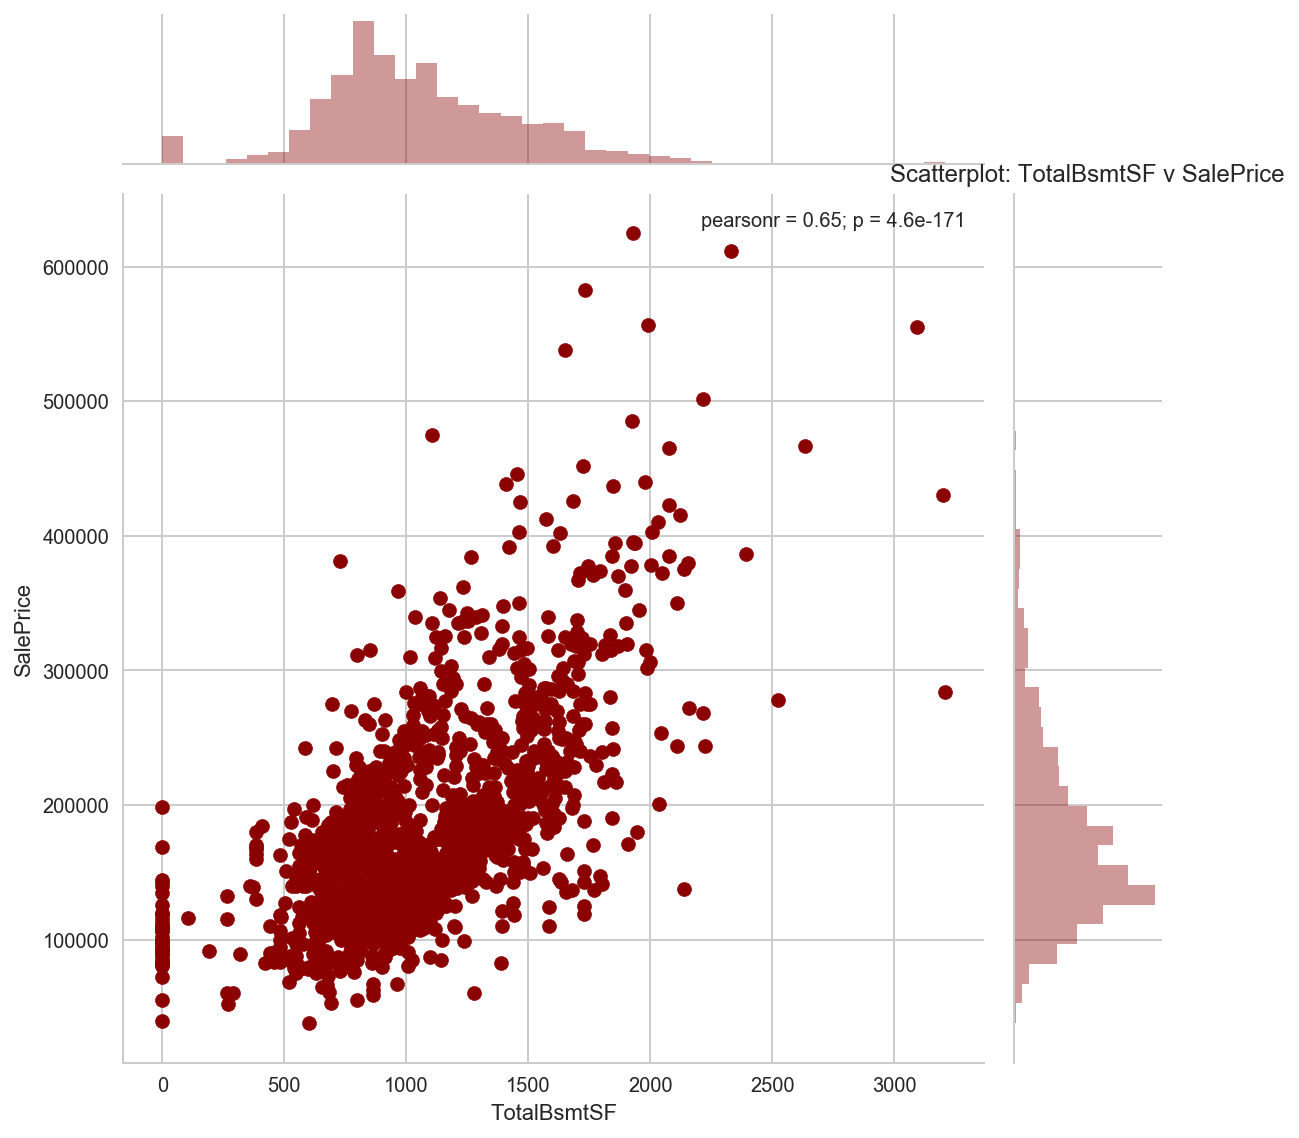

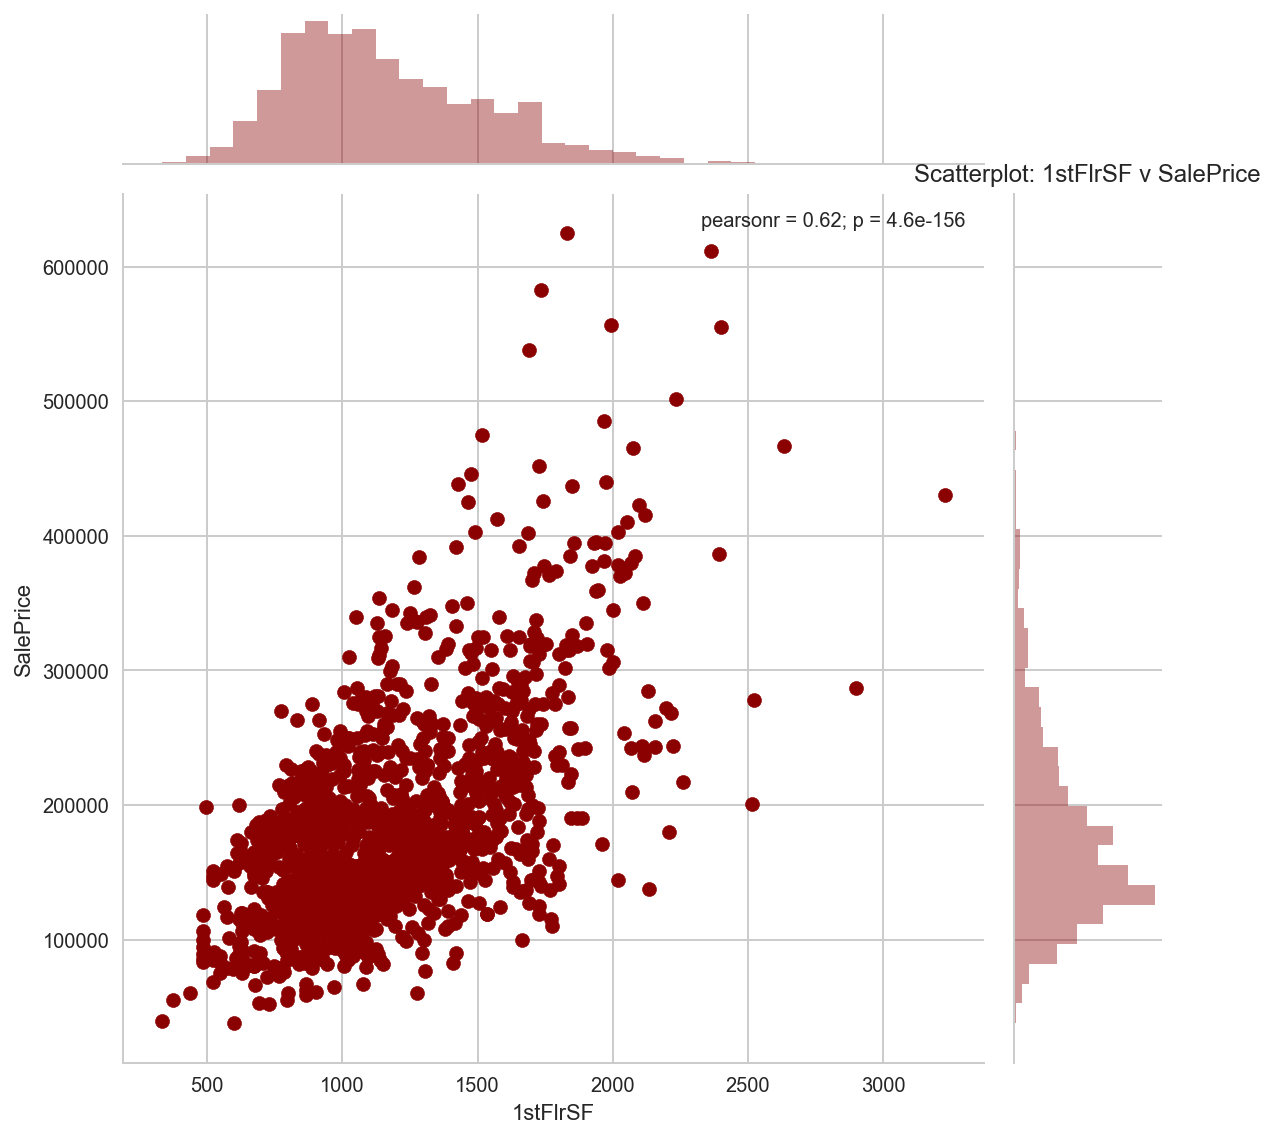

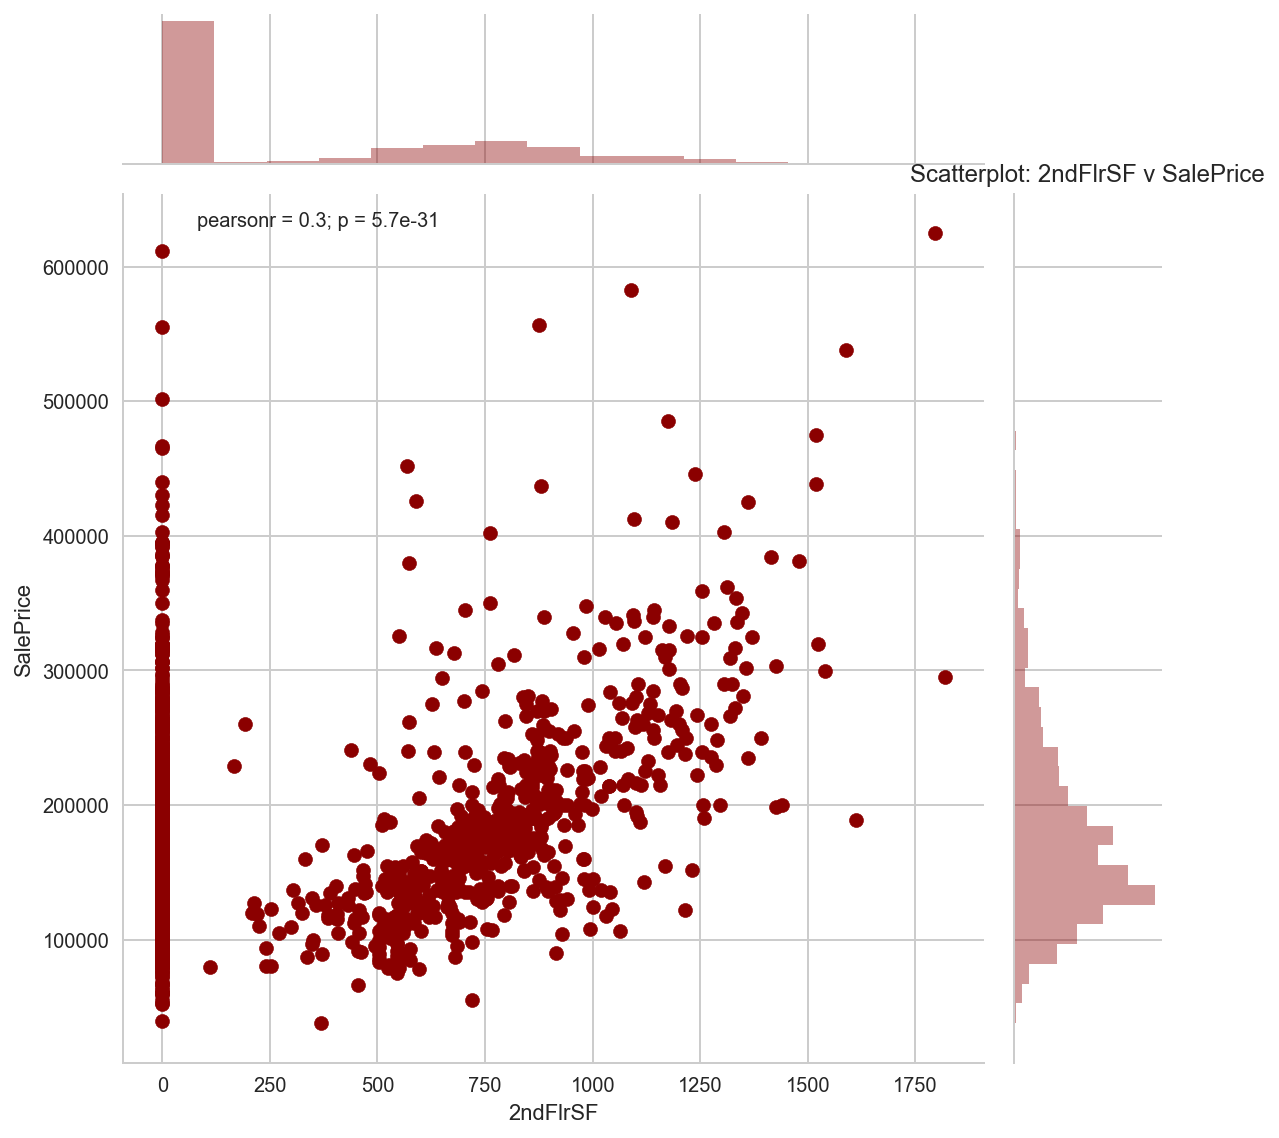

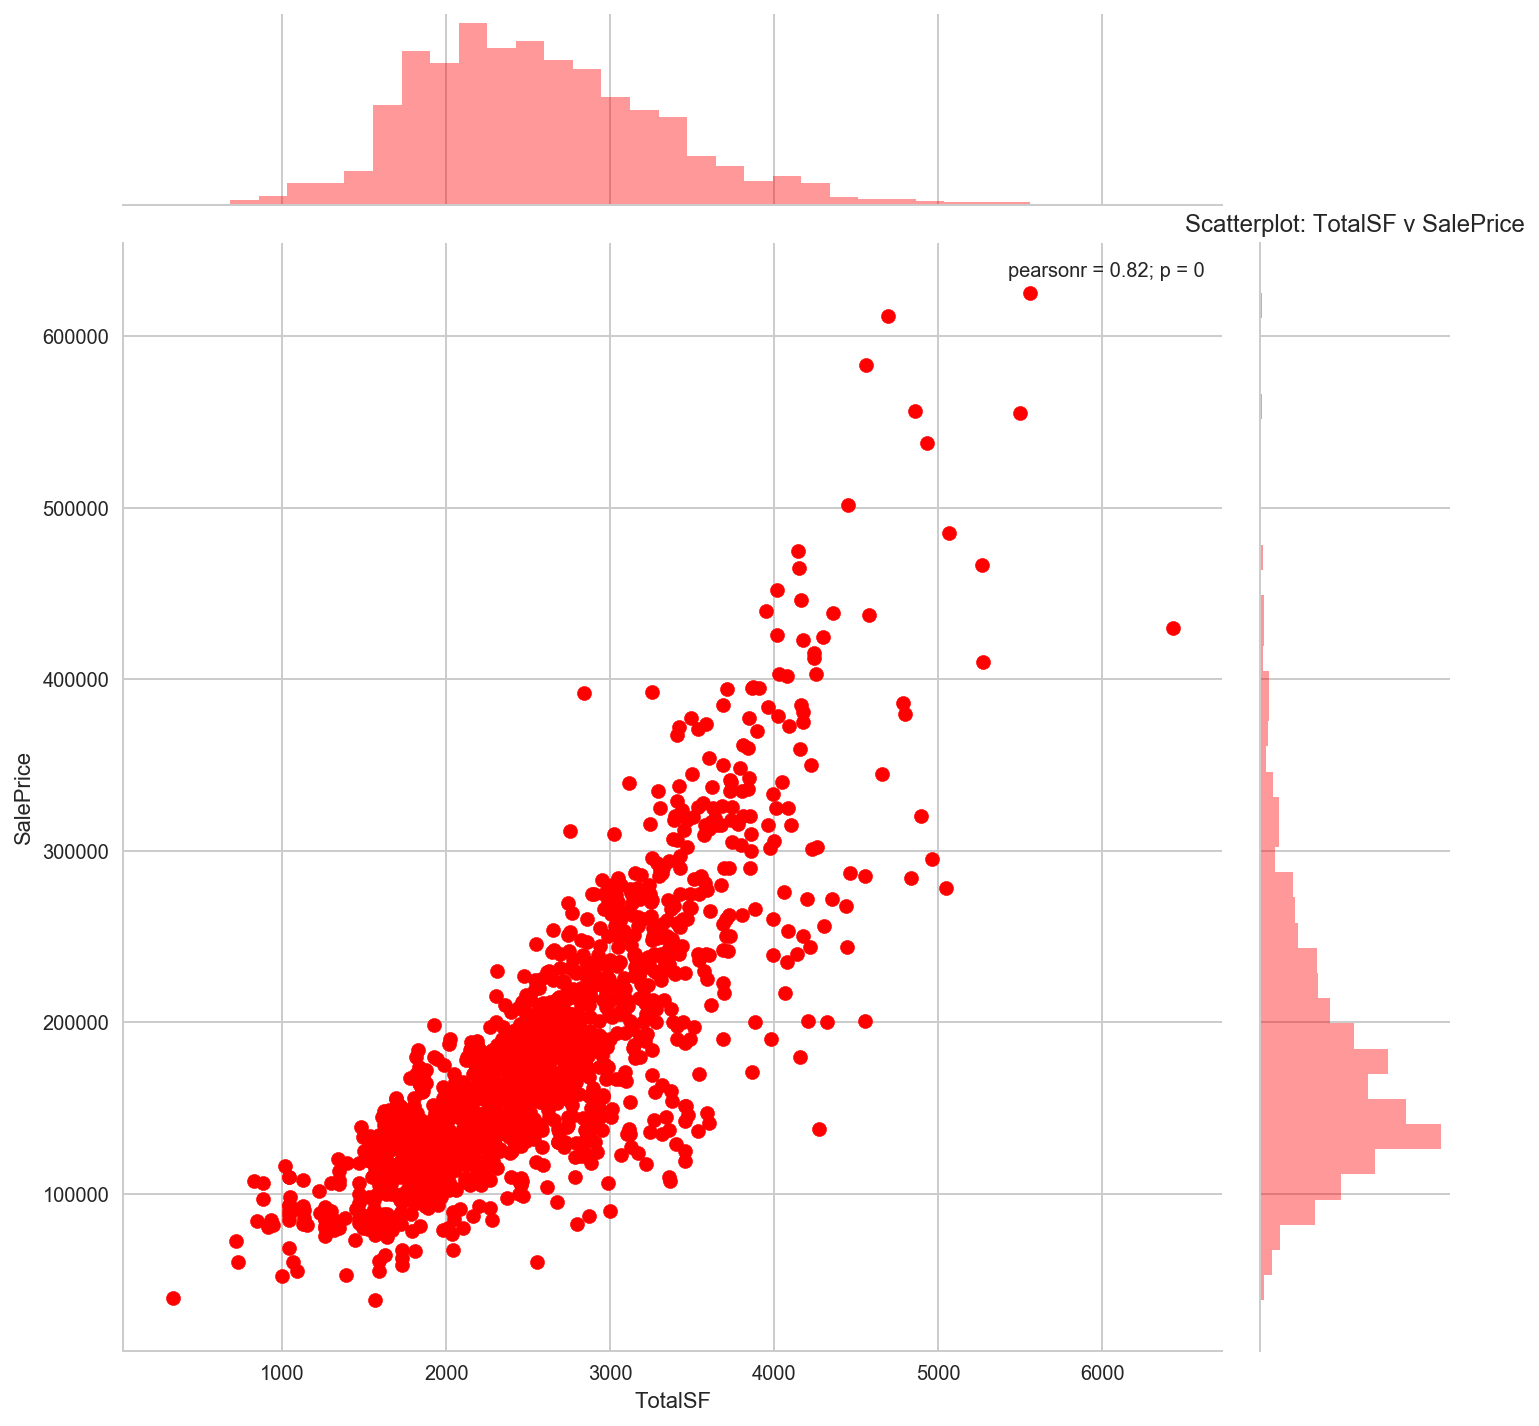

In [310]:
# Investigation of square foot variables:

# Plots of 3 individual predictors and pearsonsr:
# TotalBsmtSF Plot
sns.jointplot(house['TotalBsmtSF'], house['SalePrice'],color='darkred',size=8)
plt.title('Scatterplot: TotalBsmtSF v SalePrice')
plt.show()

# 1stFlrSF Plot
sns.jointplot(house['1stFlrSF'], house['SalePrice'],color='darkred',size=8)
plt.title('Scatterplot: 1stFlrSF v SalePrice')
plt.show()

#2ndFlrSF Plot
sns.jointplot(house['2ndFlrSF'], house['SalePrice'],color='darkred',size=8)
plt.title('Scatterplot: 2ndFlrSF v SalePrice')
plt.show()


# Create a total square footage variable
house['TotalSF'] = house['TotalBsmtSF'] + house['1stFlrSF'] + house['2ndFlrSF']

# TotalSF Plot
sns.jointplot(house['TotalSF'],house['SalePrice'],color='red',size=10)
plt.title('Scatterplot: TotalSF v SalePrice')
plt.show()

#### _Square Foot Result:_
A strong positive correlation for total house square footage so we will keep this variable!

#### 2. Year Built Investigation

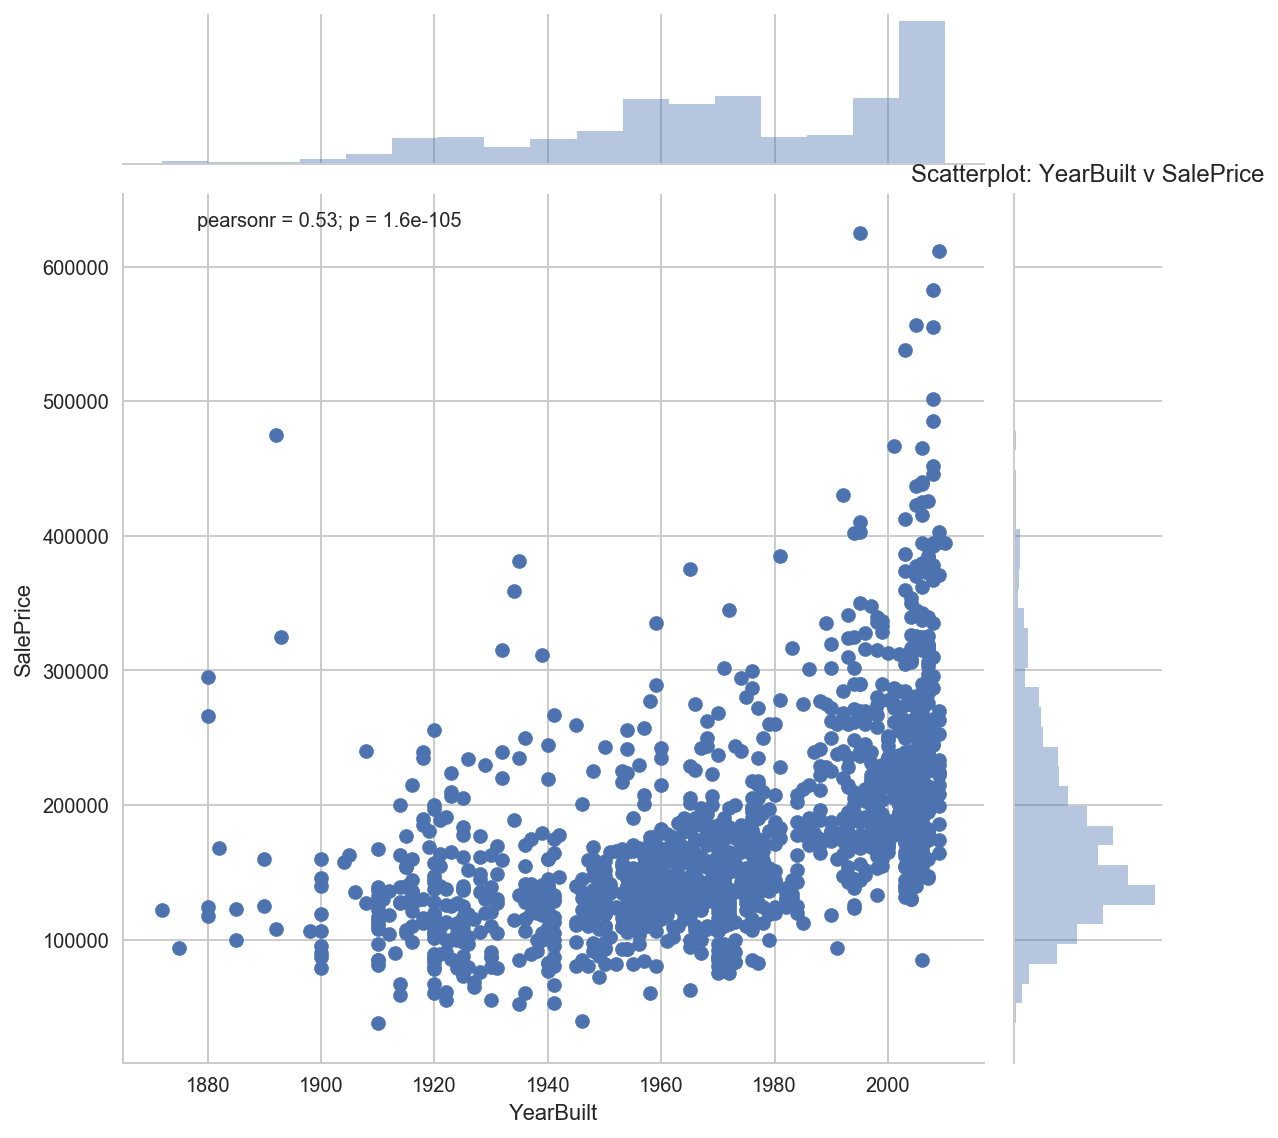

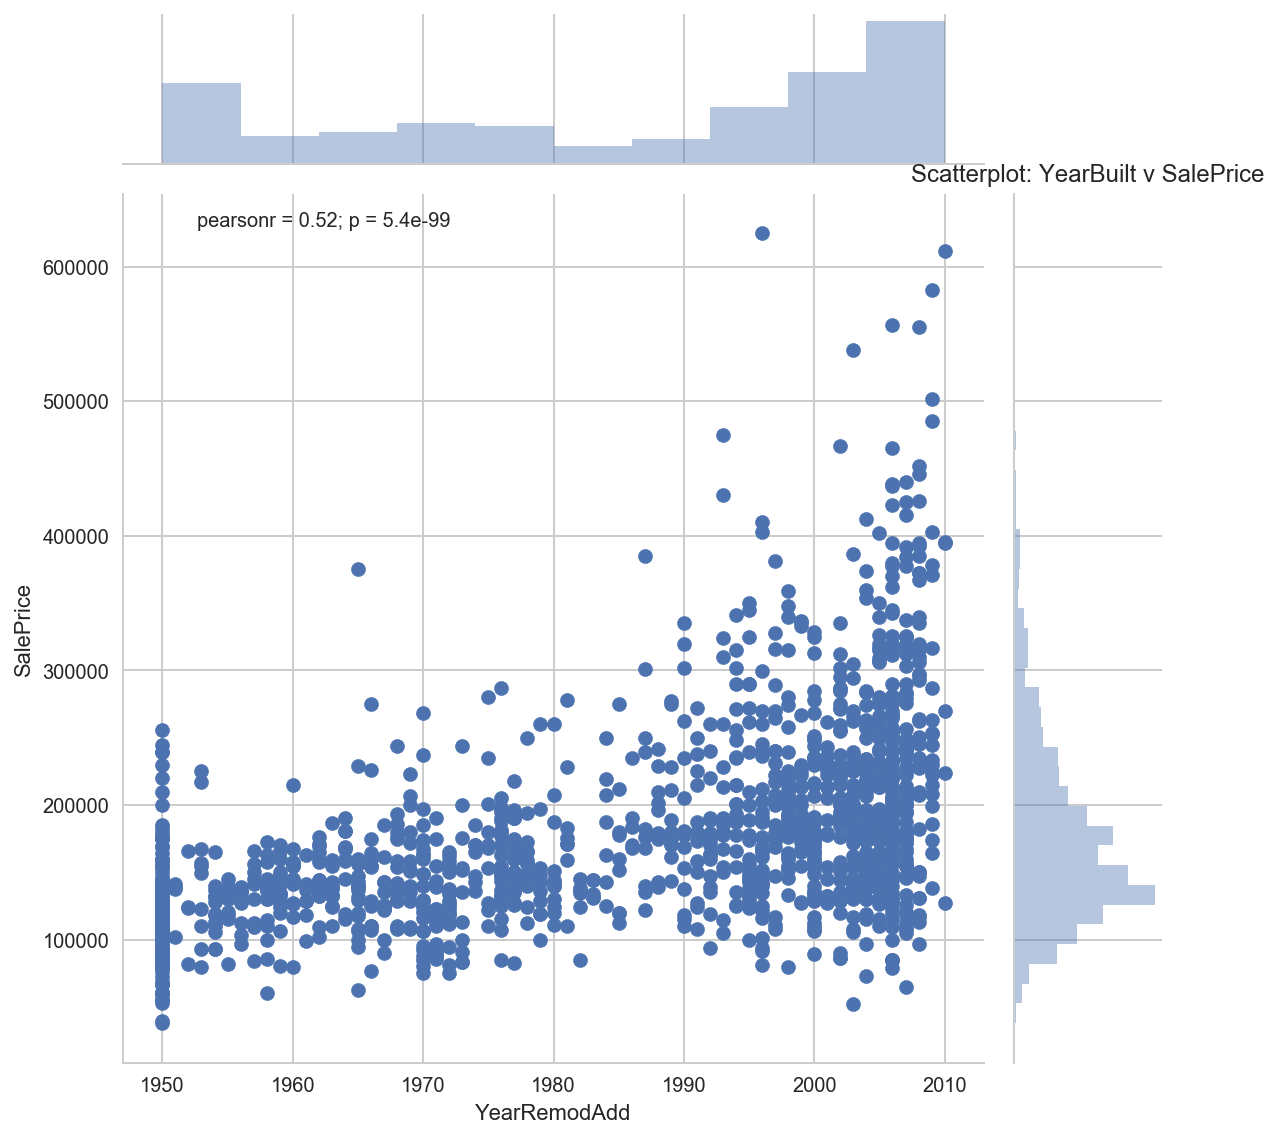

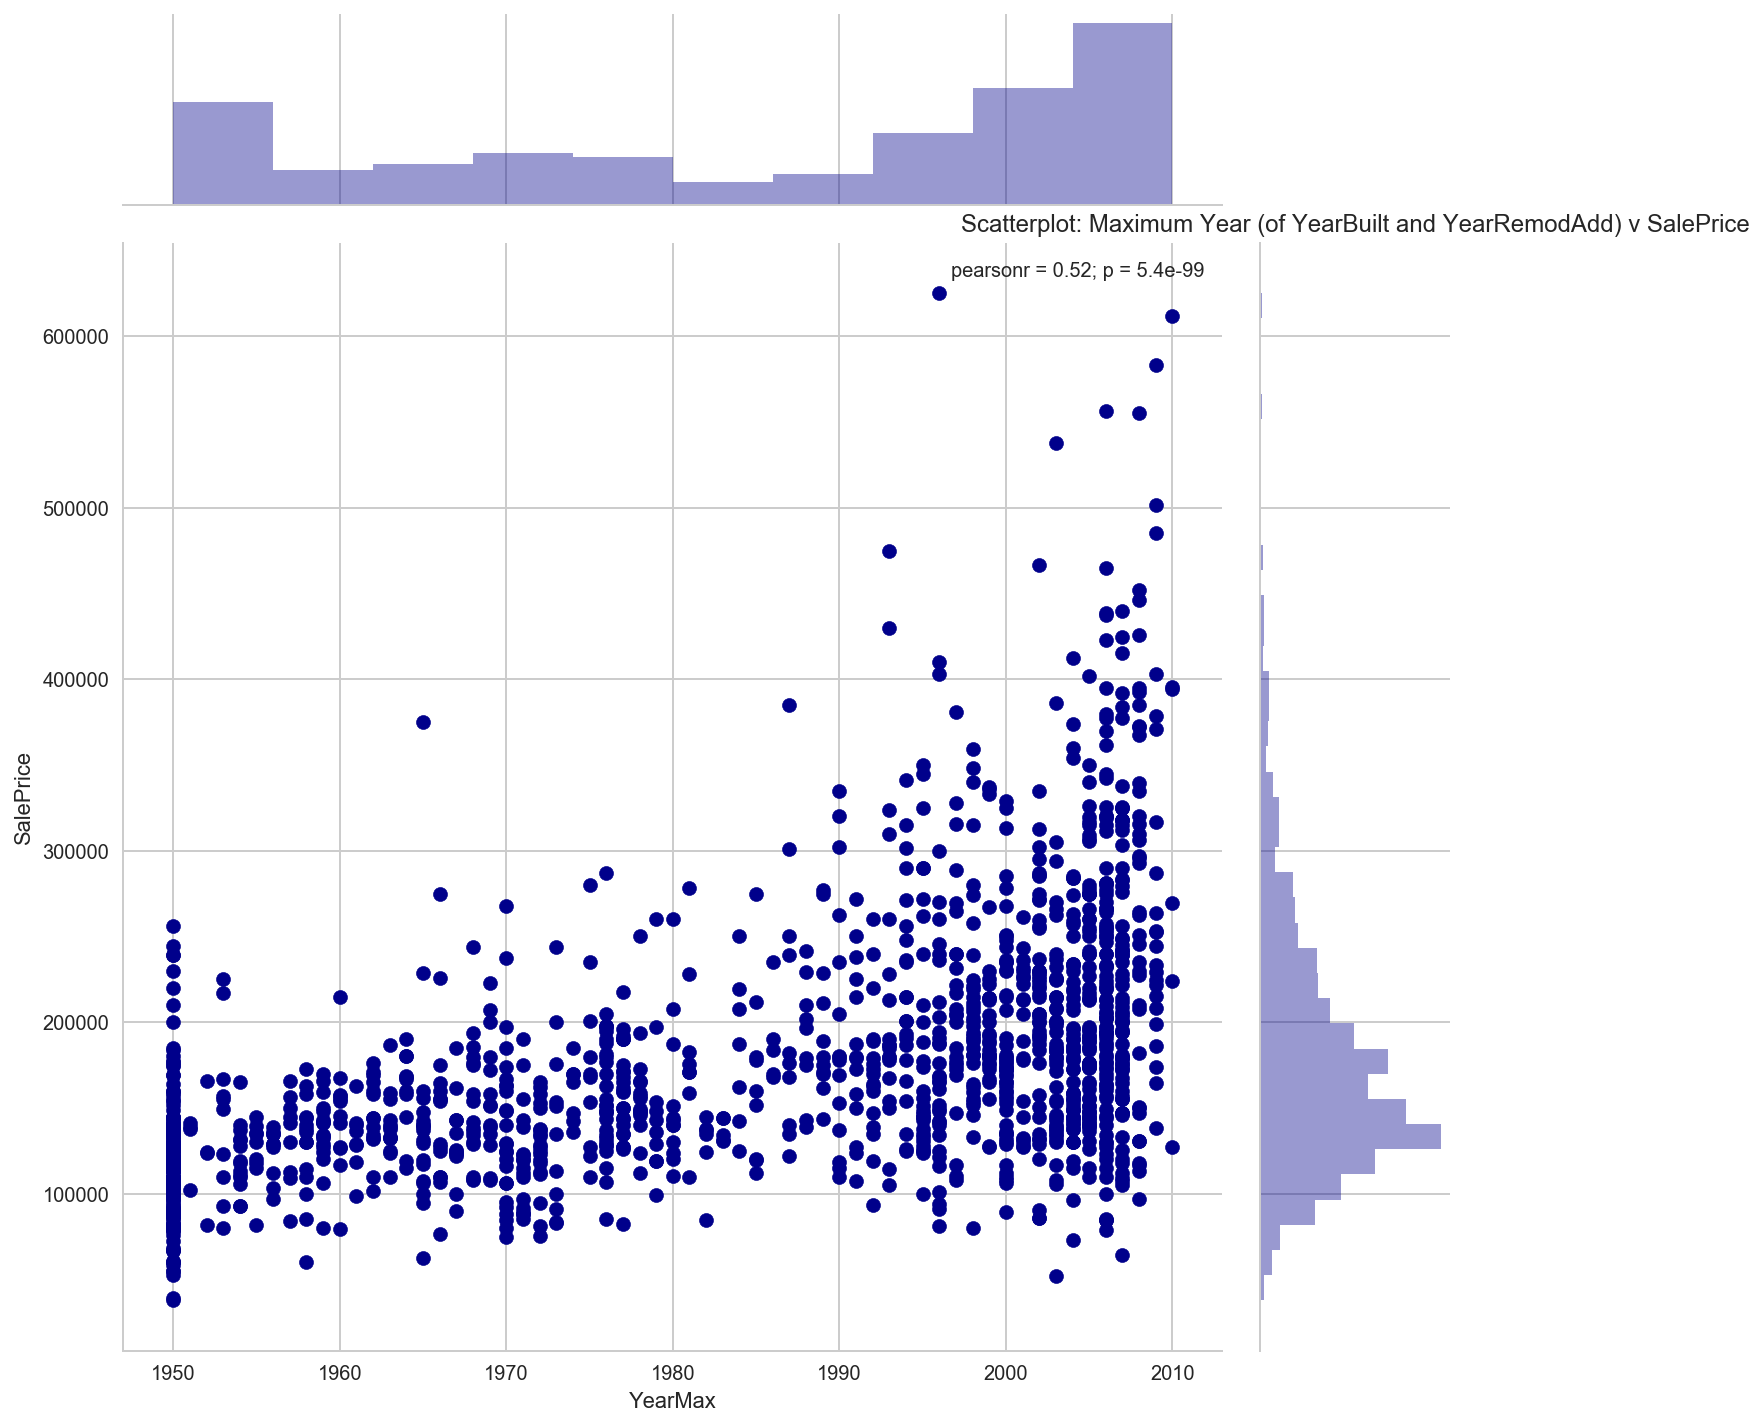

In [311]:
# YearBuilt investigation:

# YearBuilt plot:
sns.jointplot(house['YearBuilt'], house['SalePrice'], size = 8)
plt.title('Scatterplot: YearBuilt v SalePrice')
plt.show()

# YearRemodAdd:
sns.jointplot(house['YearRemodAdd'], house['SalePrice'], size=8)
plt.title('Scatterplot: YearBuilt v SalePrice')
plt.show()

# Create a most recent date field and plot
house["YearMax"] = house[['YearBuilt','YearRemodAdd']].max(axis=1)
sns.jointplot(house['YearMax'], house['SalePrice'], color='darkblue',size=10)
plt.title('Scatterplot: Maximum Year (of YearBuilt and YearRemodAdd) v SalePrice')
plt.show()

####  _YearBuilt Result:_
There is very little difference between the three correlations so we will select the highest (YearBuilt) to use in our model.

#### 3. Total Number of Bathrooms Investigation

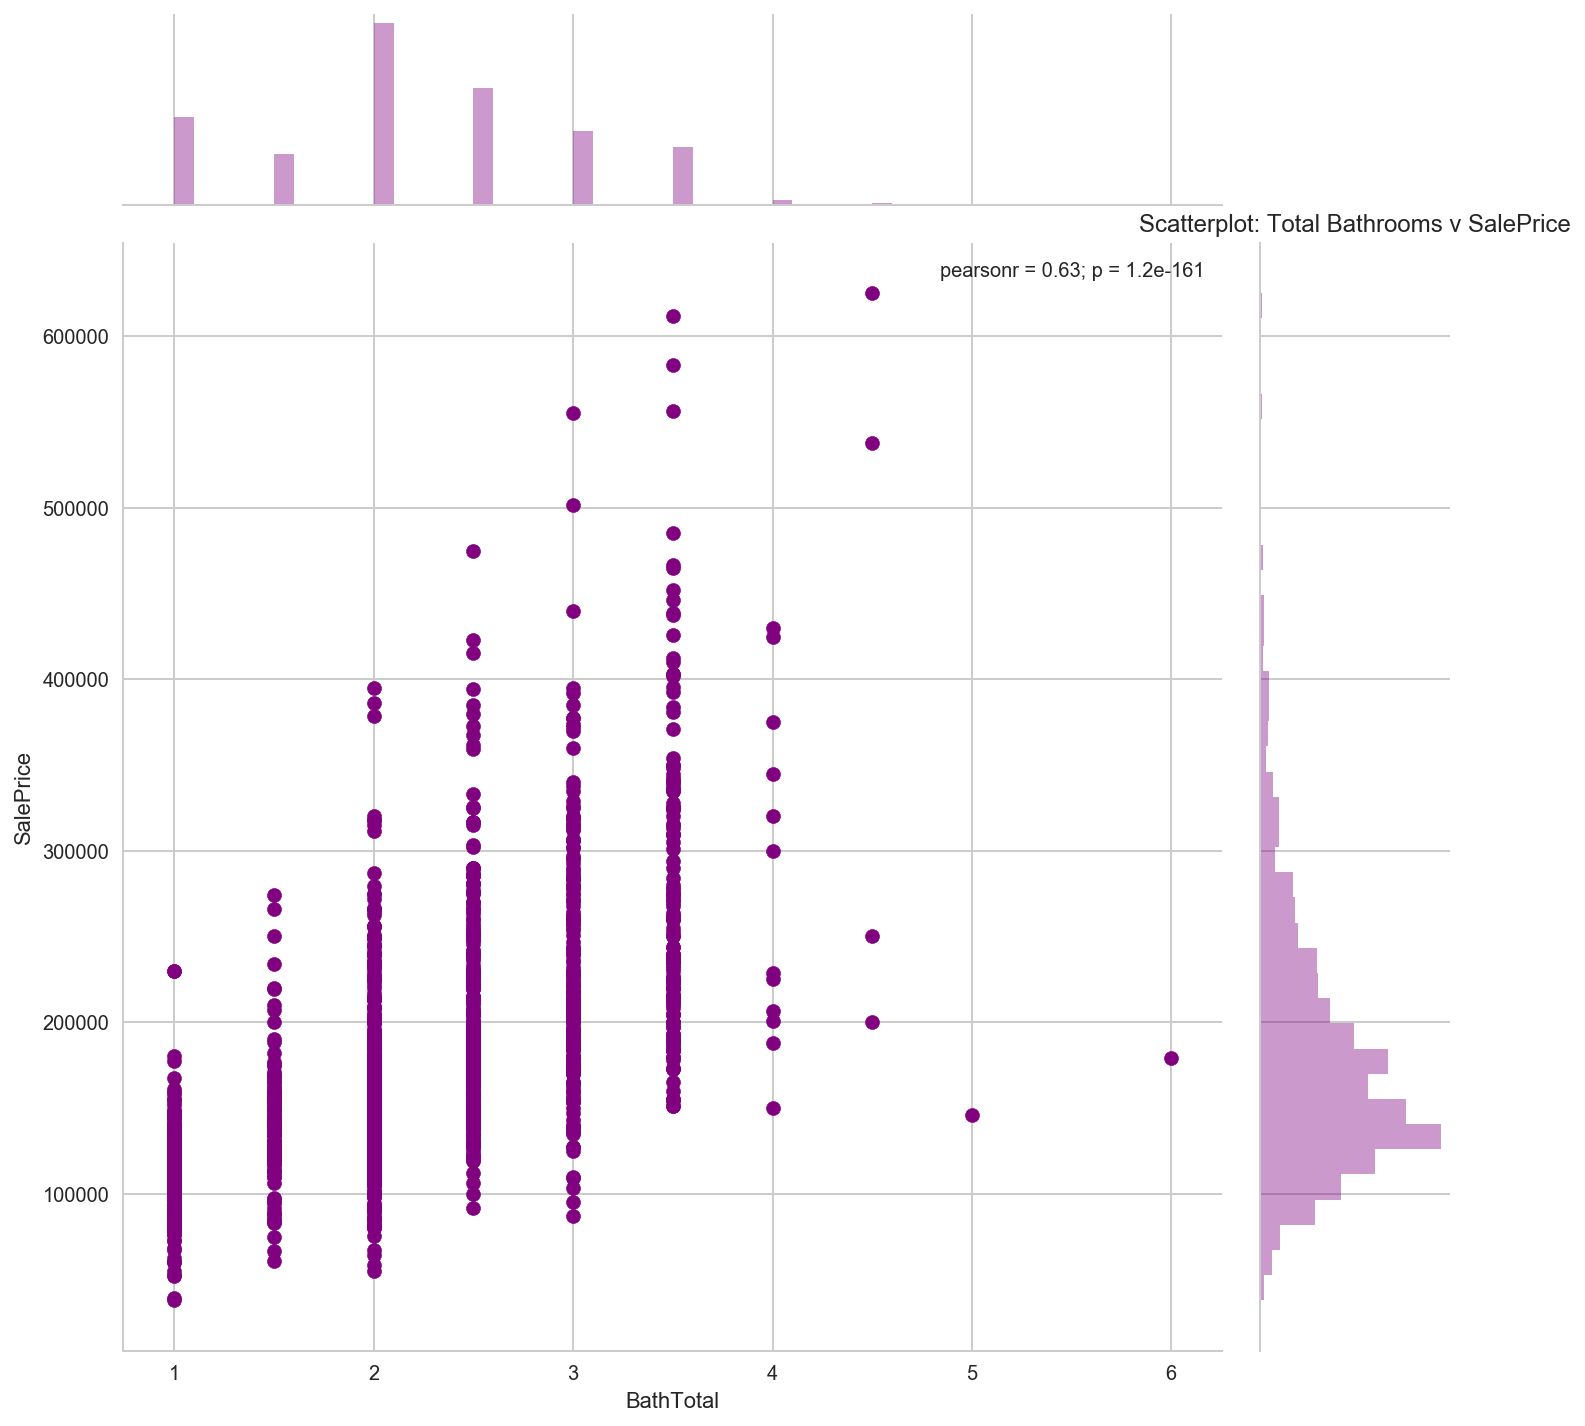

In [312]:
# Number of bathrooms investigation:

# Assume HalfBath variables are worth 0.5 to FullBathroom's 1.0
house['BathTotal'] = (house['BsmtFullBath'] + (house['BsmtHalfBath']/2) + house['FullBath'] + (house['HalfBath']/2))

# Plot new BathTotal variable
sns.jointplot(house['BathTotal'],house['SalePrice'],color='purple', size=10)
plt.title('Scatterplot: Total Bathrooms v SalePrice')
plt.show()

####  _Bathrooms Result:_
There appears to be an improvement in correlation - 0.55 for FullBath to 0.63 for BathTotal - so this variable will be kept!

#### 4. Kitchen/Bathroom Room Ratio Investigation

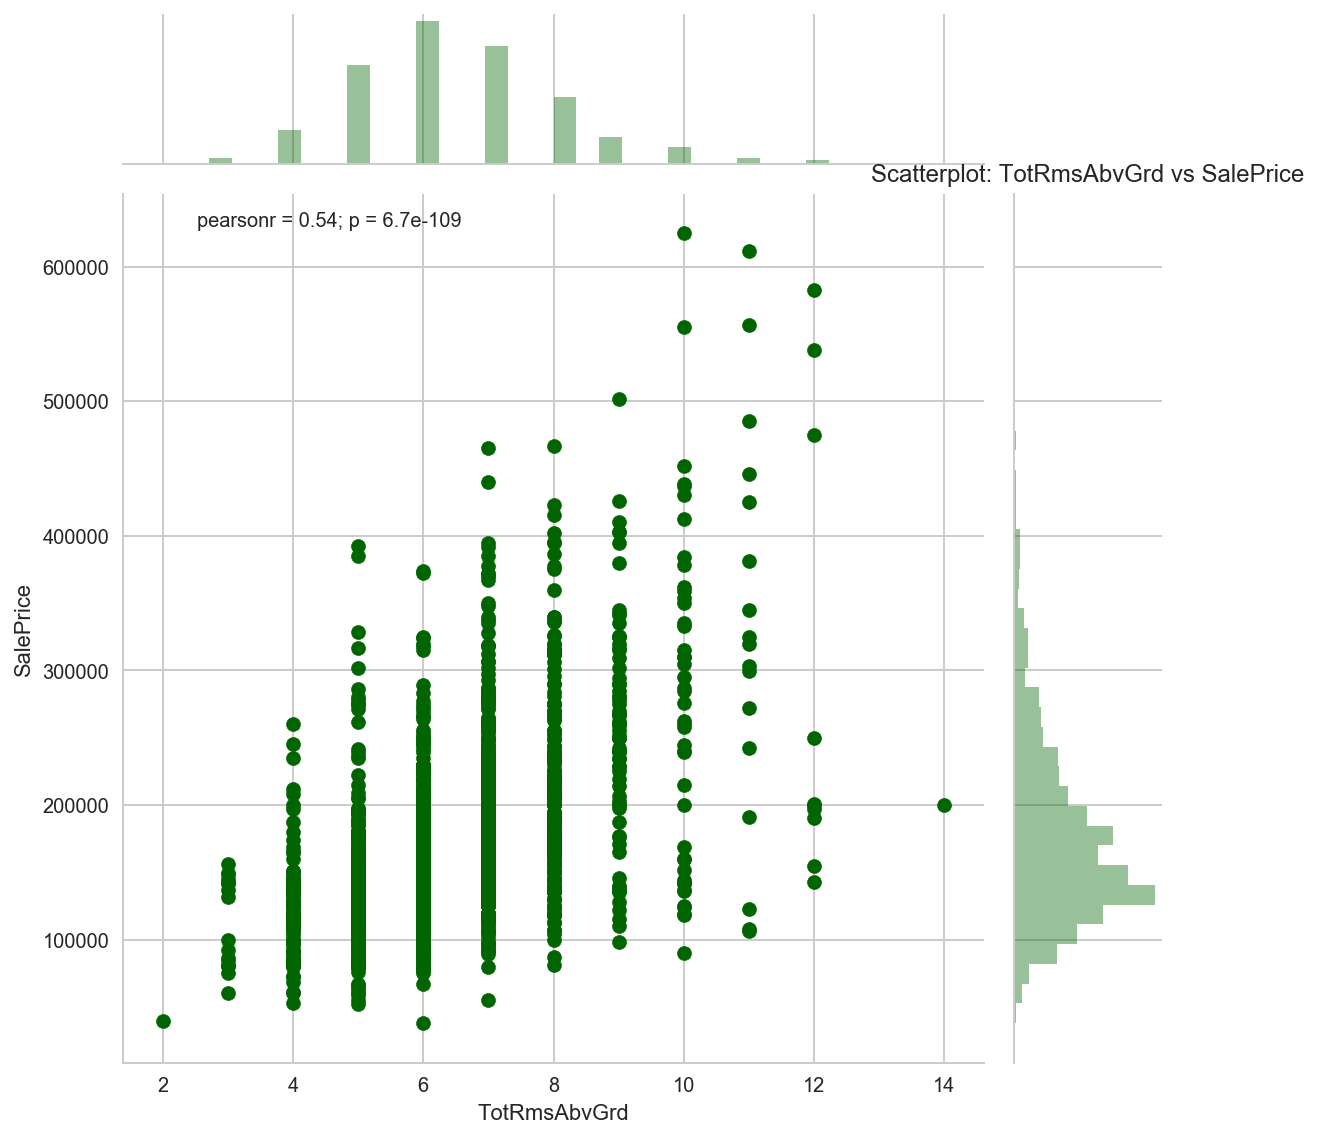

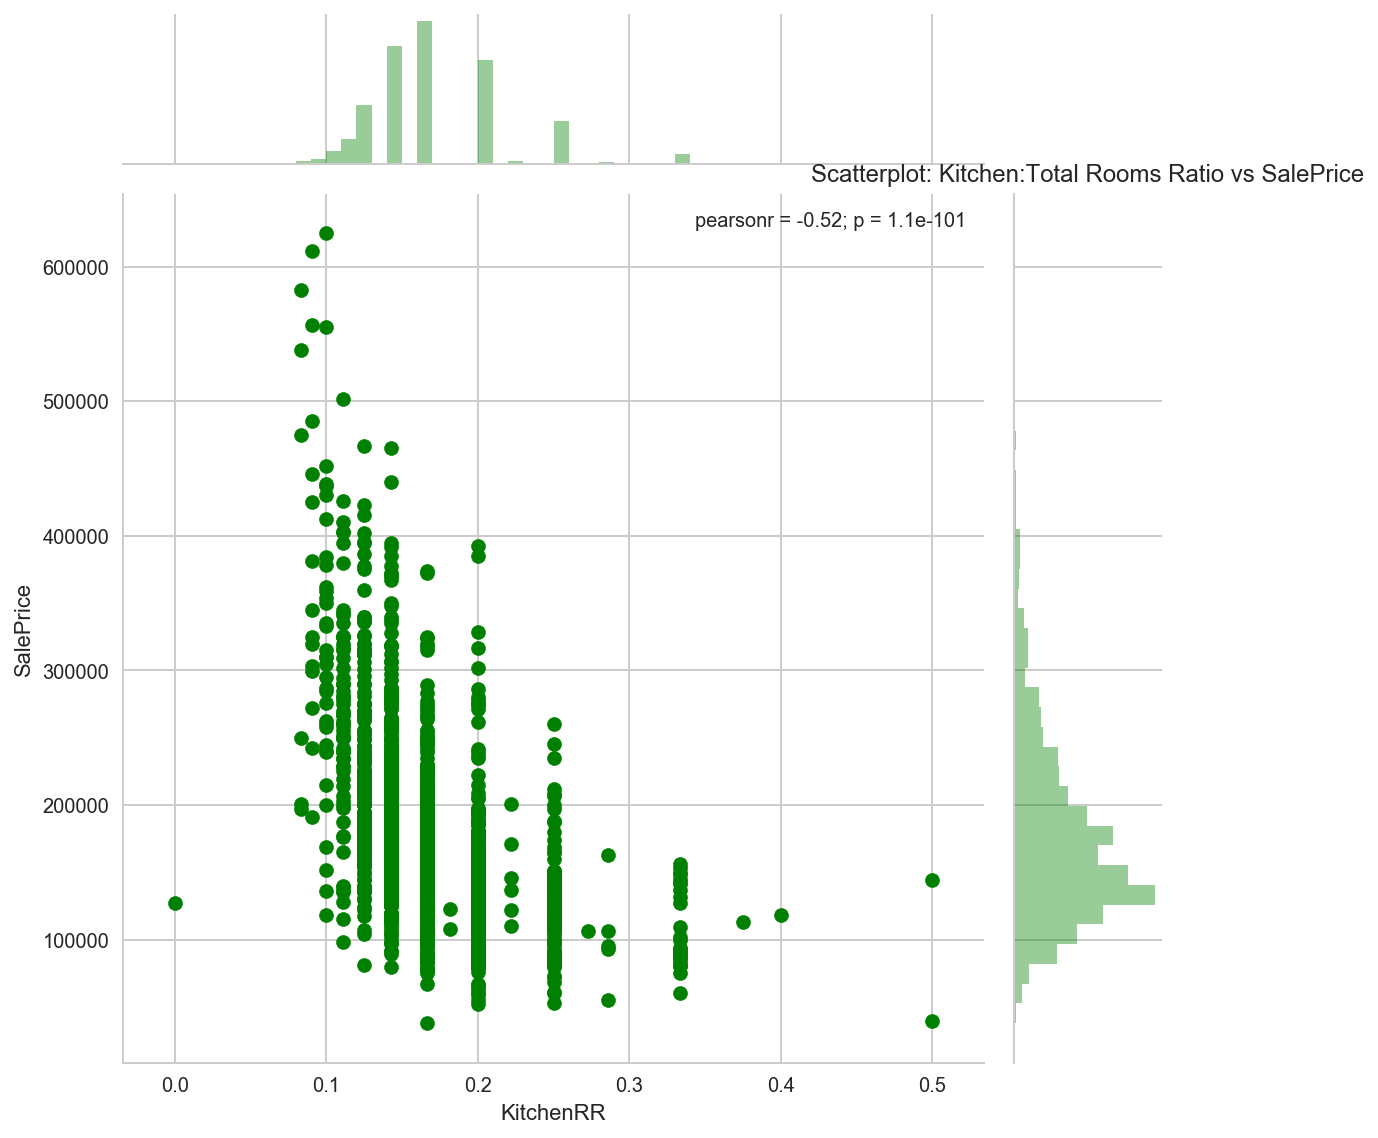

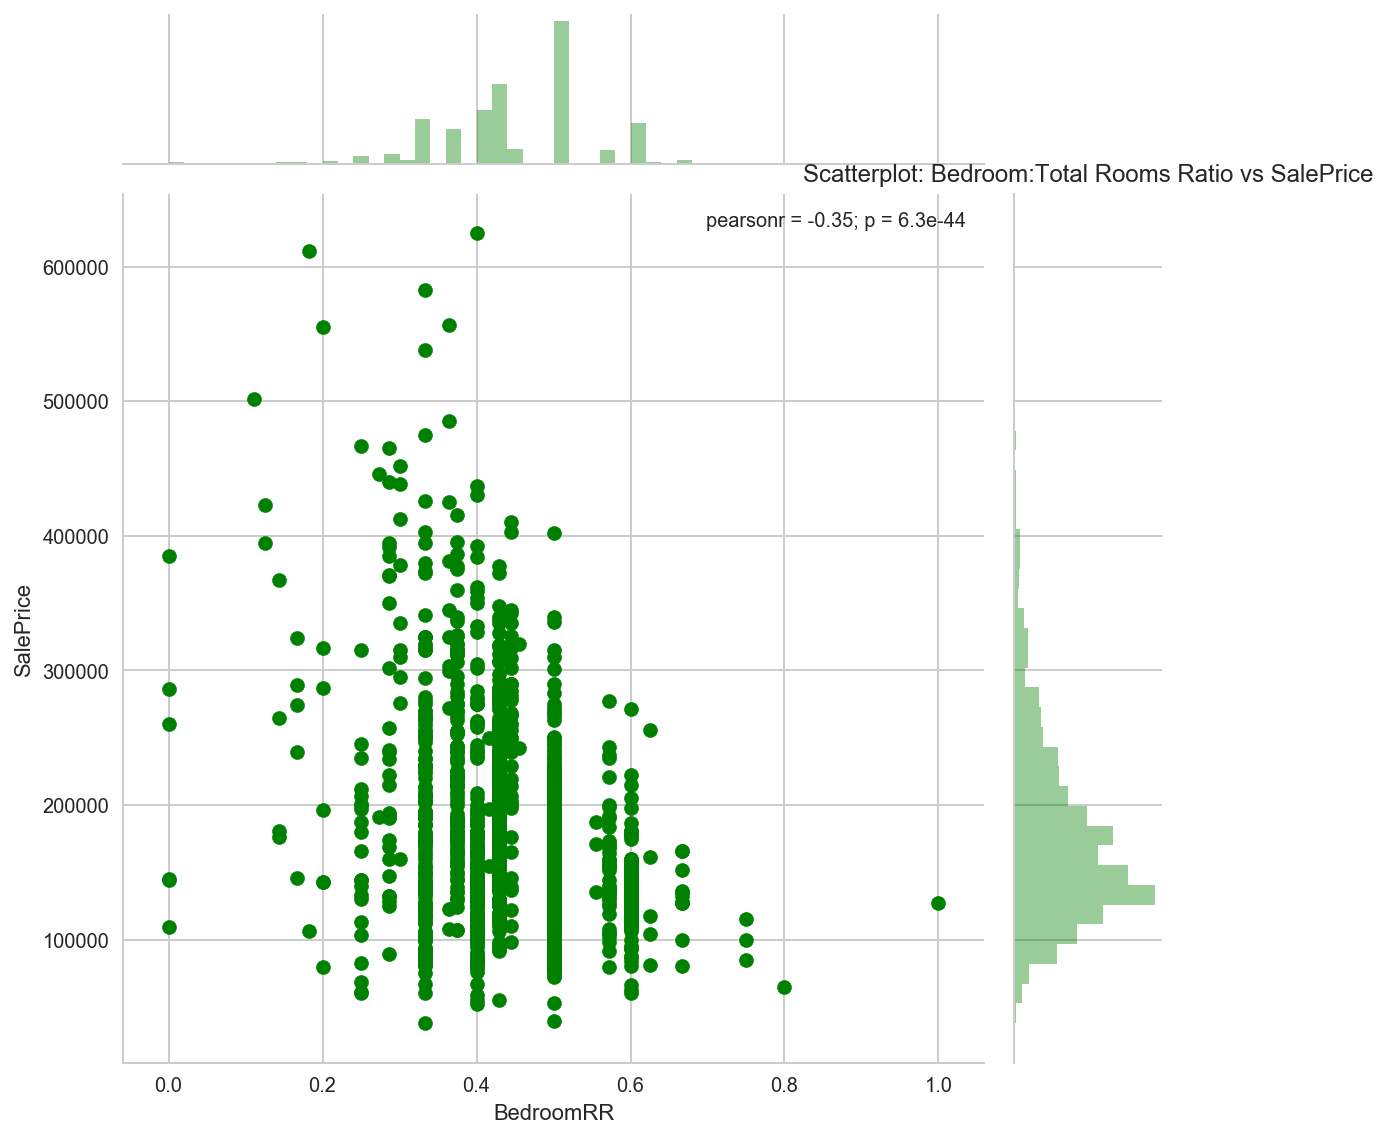

In [313]:
# Investigation of kitchen and bedroom number ratio to total rooms:

# Total Rooms vs SalePrice plot
sns.jointplot(house['TotRmsAbvGrd'],house['SalePrice'],color='darkgreen',size=8)
plt.title('Scatterplot: TotRmsAbvGrd vs SalePrice')
plt.show()

# Calculate the ratio of kitchens/bathrooms to total room numbers:

# Kitchen ratio and plot:
house['KitchenRR'] = house['KitchenAbvGr']/house['TotRmsAbvGrd']

sns.jointplot(house['KitchenRR'],house['SalePrice'],color='green',size=8)
plt.title('Scatterplot: Kitchen:Total Rooms Ratio vs SalePrice')
plt.show()

# Bedroom ratio and plot:
house['BedroomRR'] = house['BedroomAbvGr']/house['TotRmsAbvGrd']

sns.jointplot(house['BedroomRR'],house['SalePrice'],color='green', size=8)
plt.title('Scatterplot: Bedroom:Total Rooms Ratio vs SalePrice')
plt.show()

#### _Bedroom and Kitchen Room Ratio Result:_
The moderate negative correlation for both new variables shows improvement in relationships however the calculated ratio is driven by the total rooms above ground rather than the no of kitchens and bedrooms. This total rooms predictor has a higher coefficient. I will therefore not integrate these new variables into the model.

#### 5. Lot Shape and Slope Investigation

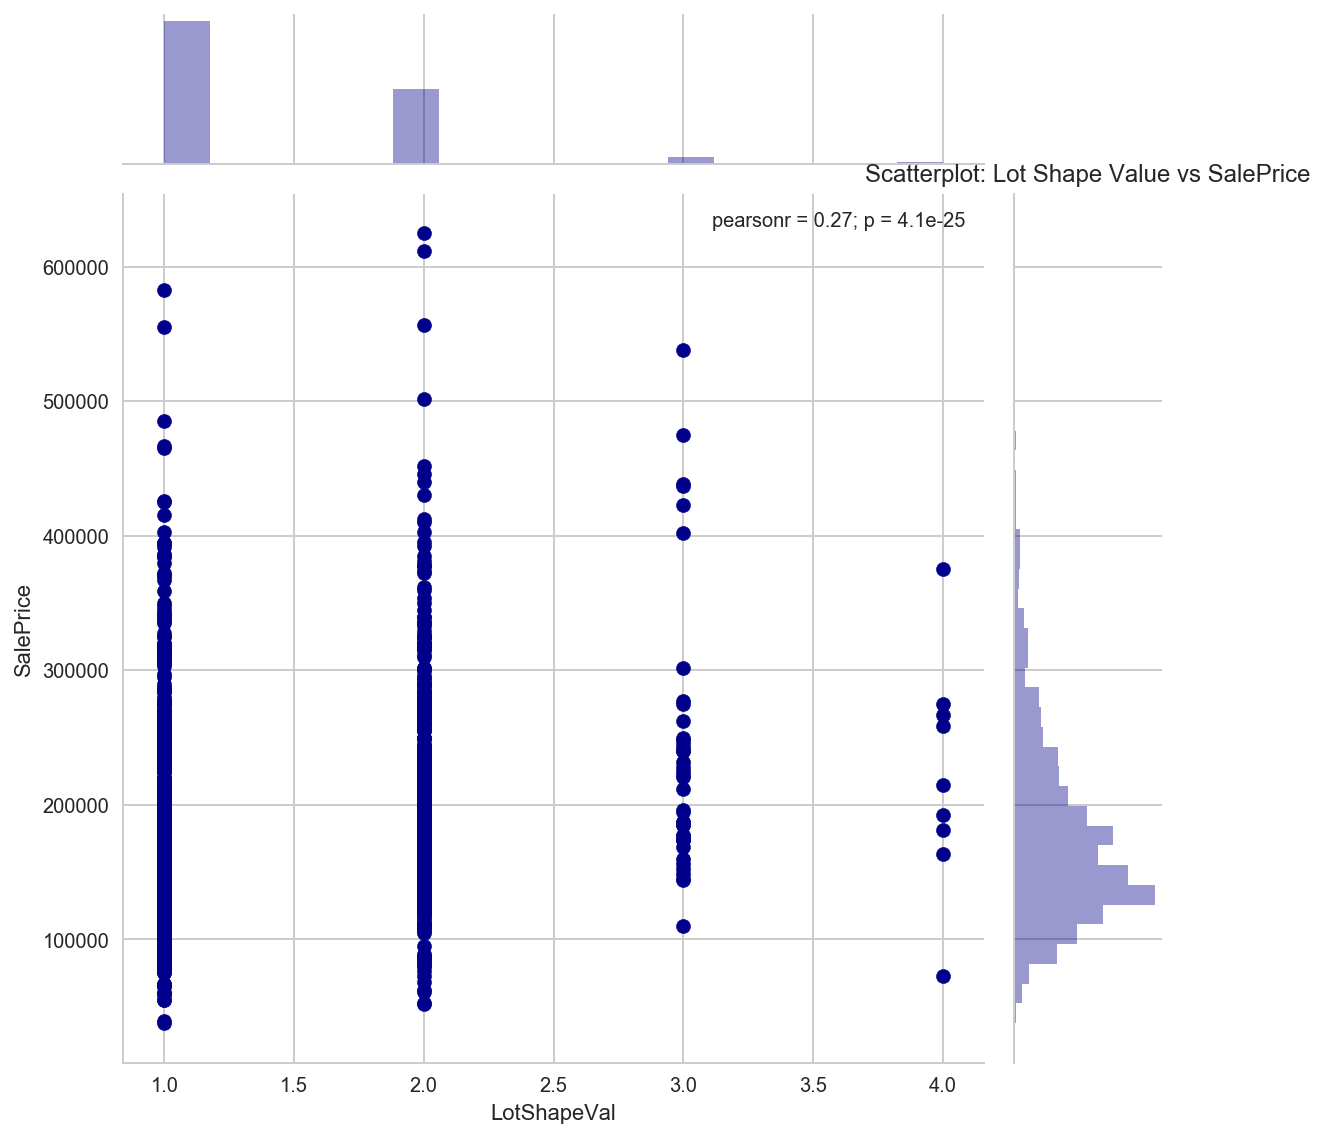

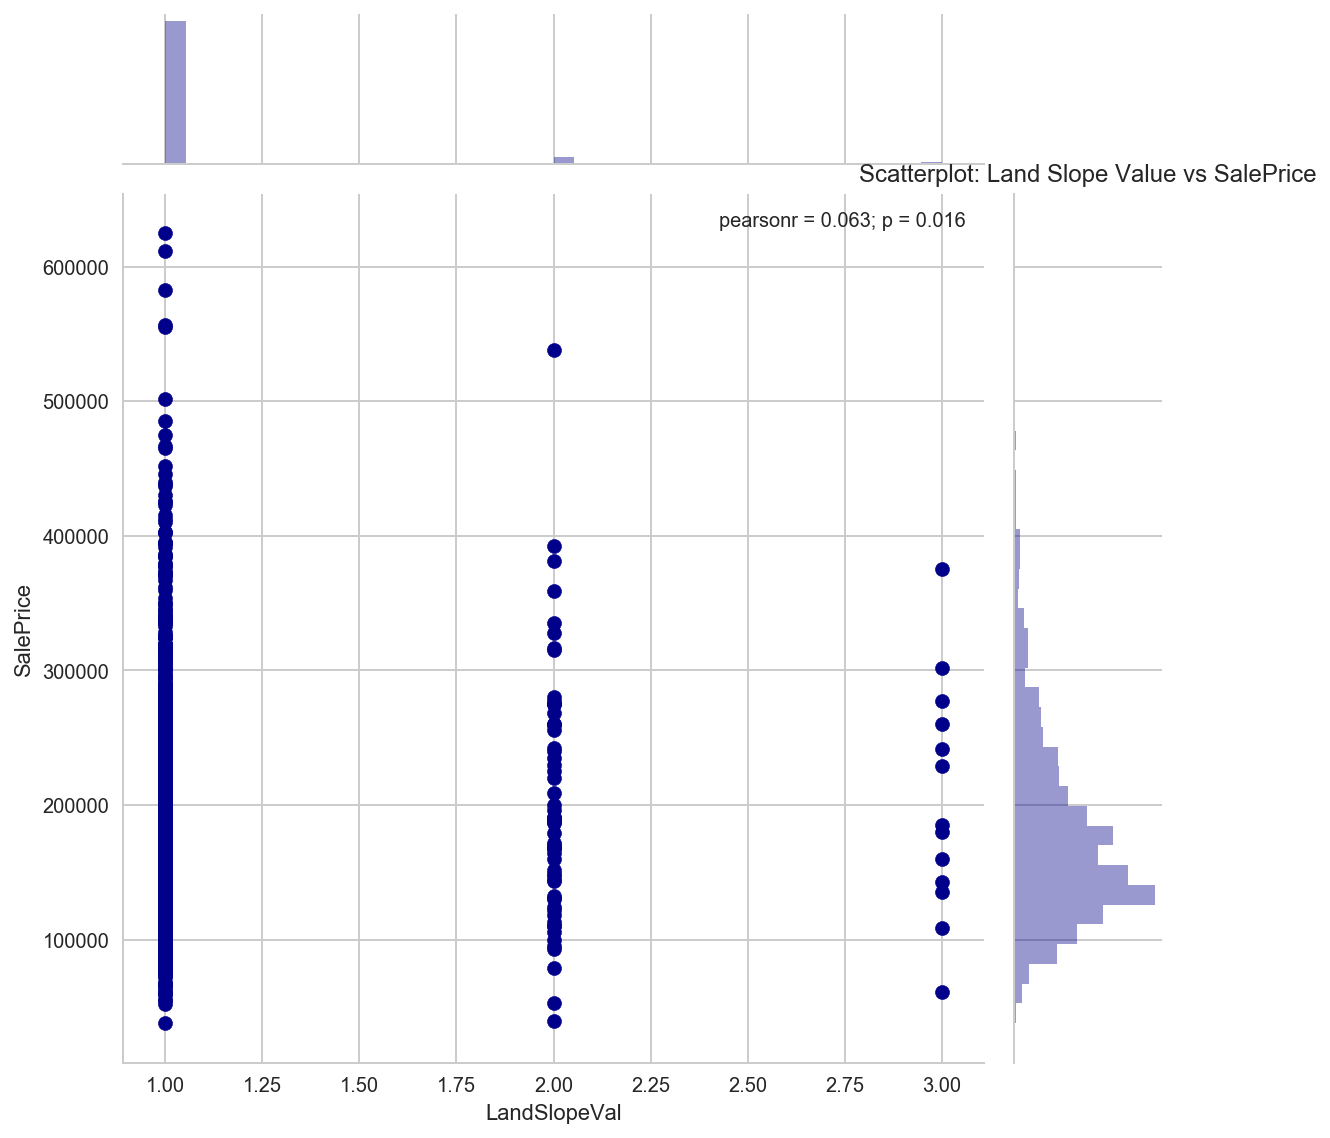

In [314]:
# Lot shape and slope investigation:

# Create value representation of lot shape:
LotShape_dict = {"Reg": 1, "IR1": 2, "IR2": 3, "IR3": 4}    
house["LotShapeVal"] = house["LotShape"].map(LotShape_dict).astype(int)

# Plot LotShapeVal
sns.jointplot(house['LotShapeVal'], house['SalePrice'], color='darkblue',size = 8)
plt.title('Scatterplot: Lot Shape Value vs SalePrice')
plt.show()

# Create value representation of slope:
LandSlope_dict = {"Gtl": 1, "Mod": 2, "Sev": 3}    
house["LandSlopeVal"] = house["LandSlope"].map(LandSlope_dict).astype(int)

# Plot LandSlopeVal
sns.jointplot(house['LandSlopeVal'], house['SalePrice'], color='darkblue', size = 8)
plt.title('Scatterplot: Land Slope Value vs SalePrice')
plt.show()

#### _Lot Shape and Land Slope result:_
There is minor correlation with LotShape and negligible with LandSlope so we will not integrate these into our fixed model.

#### 6. Neighborhood Investigation

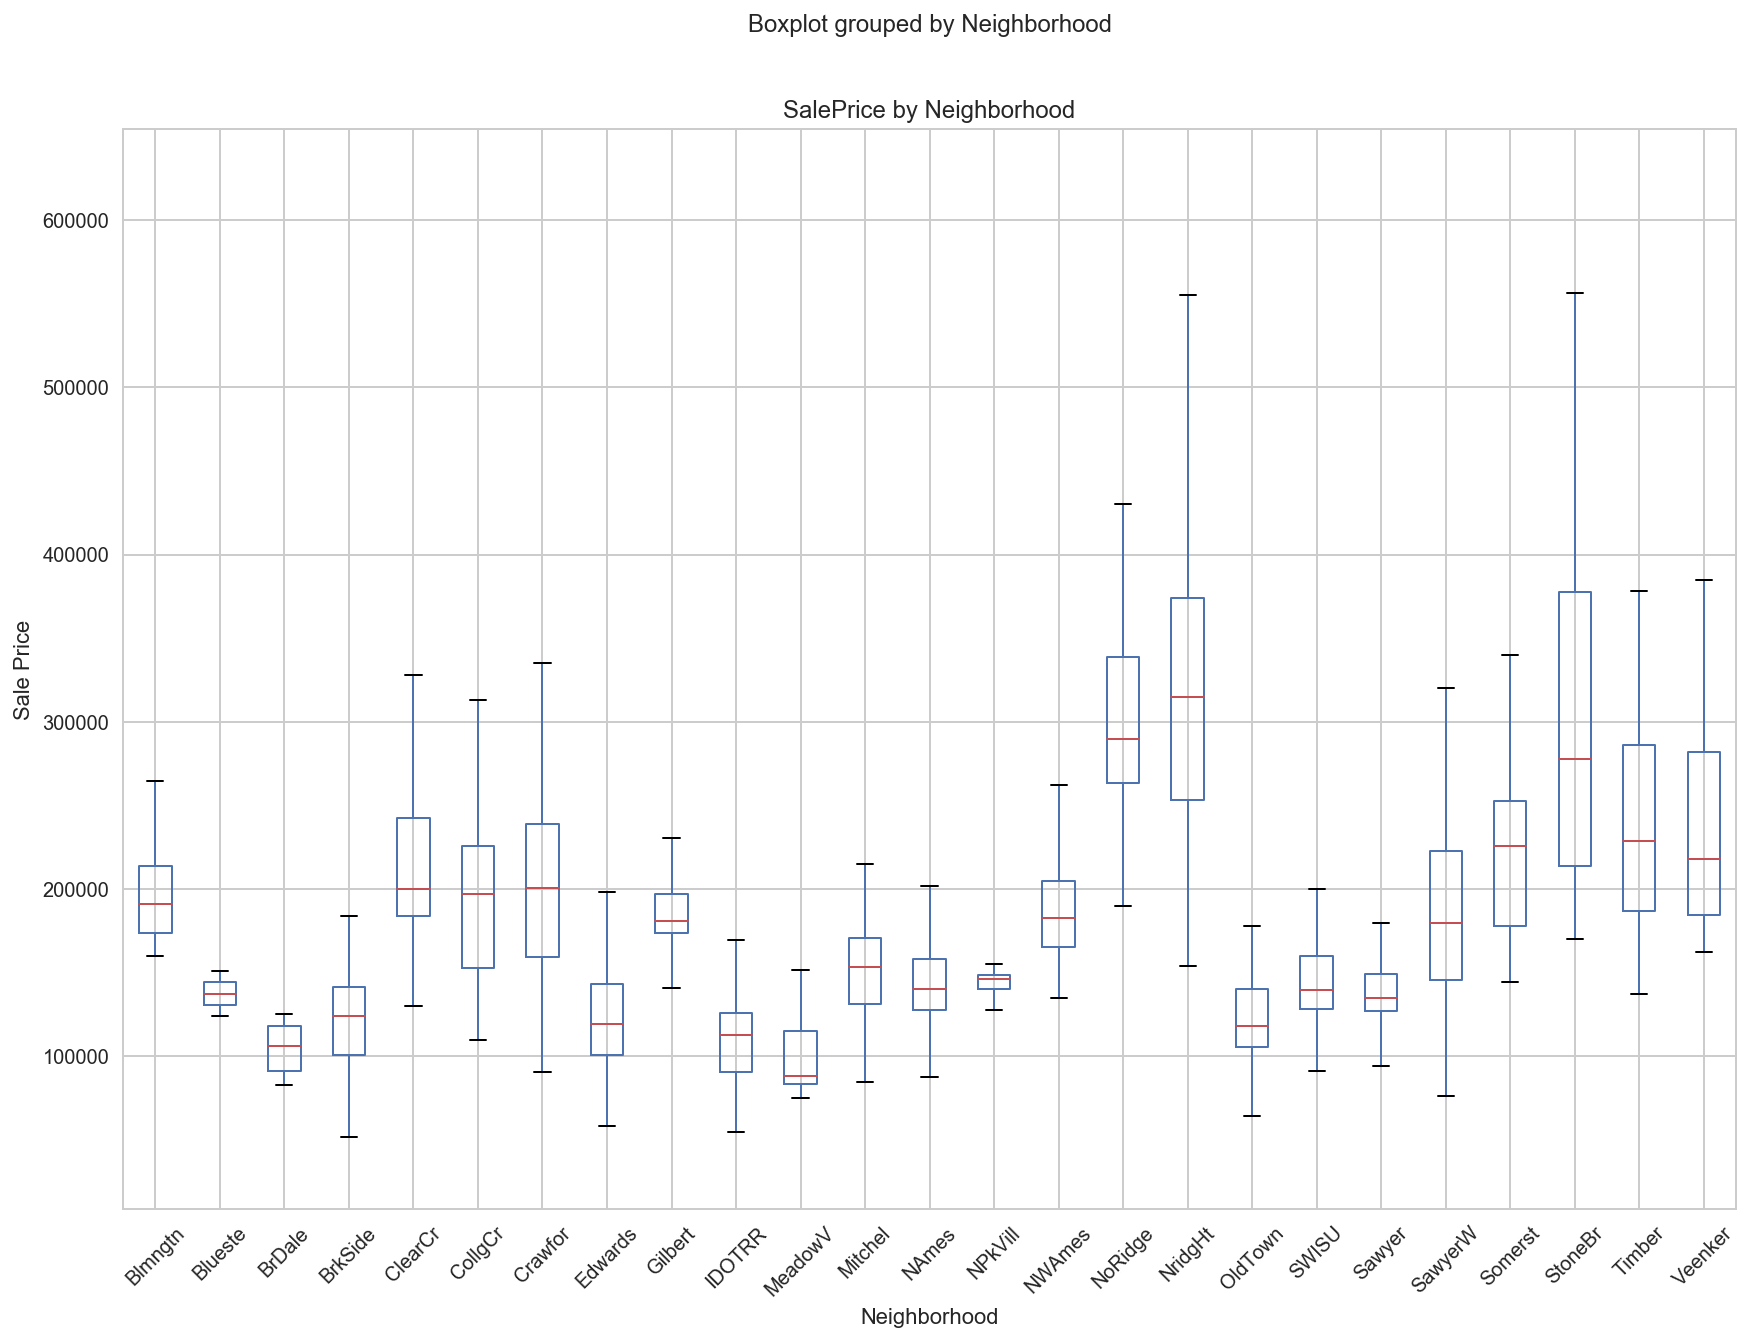

In [315]:
# BoxPlot of Neighborhood by SalePrice

house.boxplot(column='SalePrice', by='Neighborhood',rot=45,figsize=(14,10))
plt.title("SalePrice by Neighborhood")
plt.ylabel("Sale Price")

There definitely appear to be some suburbs (NrridgeHt, StoneBr, NoRidge) that greater IQR and median sale prices but because we are unable to convert this field into a numeric version (unless we geocode to coordinates and calculate the distance) we cannot integrate this feature into the model.

## Fixed Model Development

Final feature selection for FIXED model development:
As discussed above, I will include combined SF and total number of bathrooms variables in my fixed characteristics model. I will also include YearBuilt, garage variables, fireplaces and lot (area and frontage) in my final model.

- TotalSF:          0.825066
- GrLivArea:        0.720516
- GarageCars:       0.649256
- GarageArea:       0.636964
- BathTotal:        0.635939
- TotRmsAbvGrd:     0.537462
- YearBuilt:        0.535279
- GarageYrBlt:      0.481640
- Fireplaces:       0.466765
- LotArea:          0.269866
- LotFrontage:      0.201706

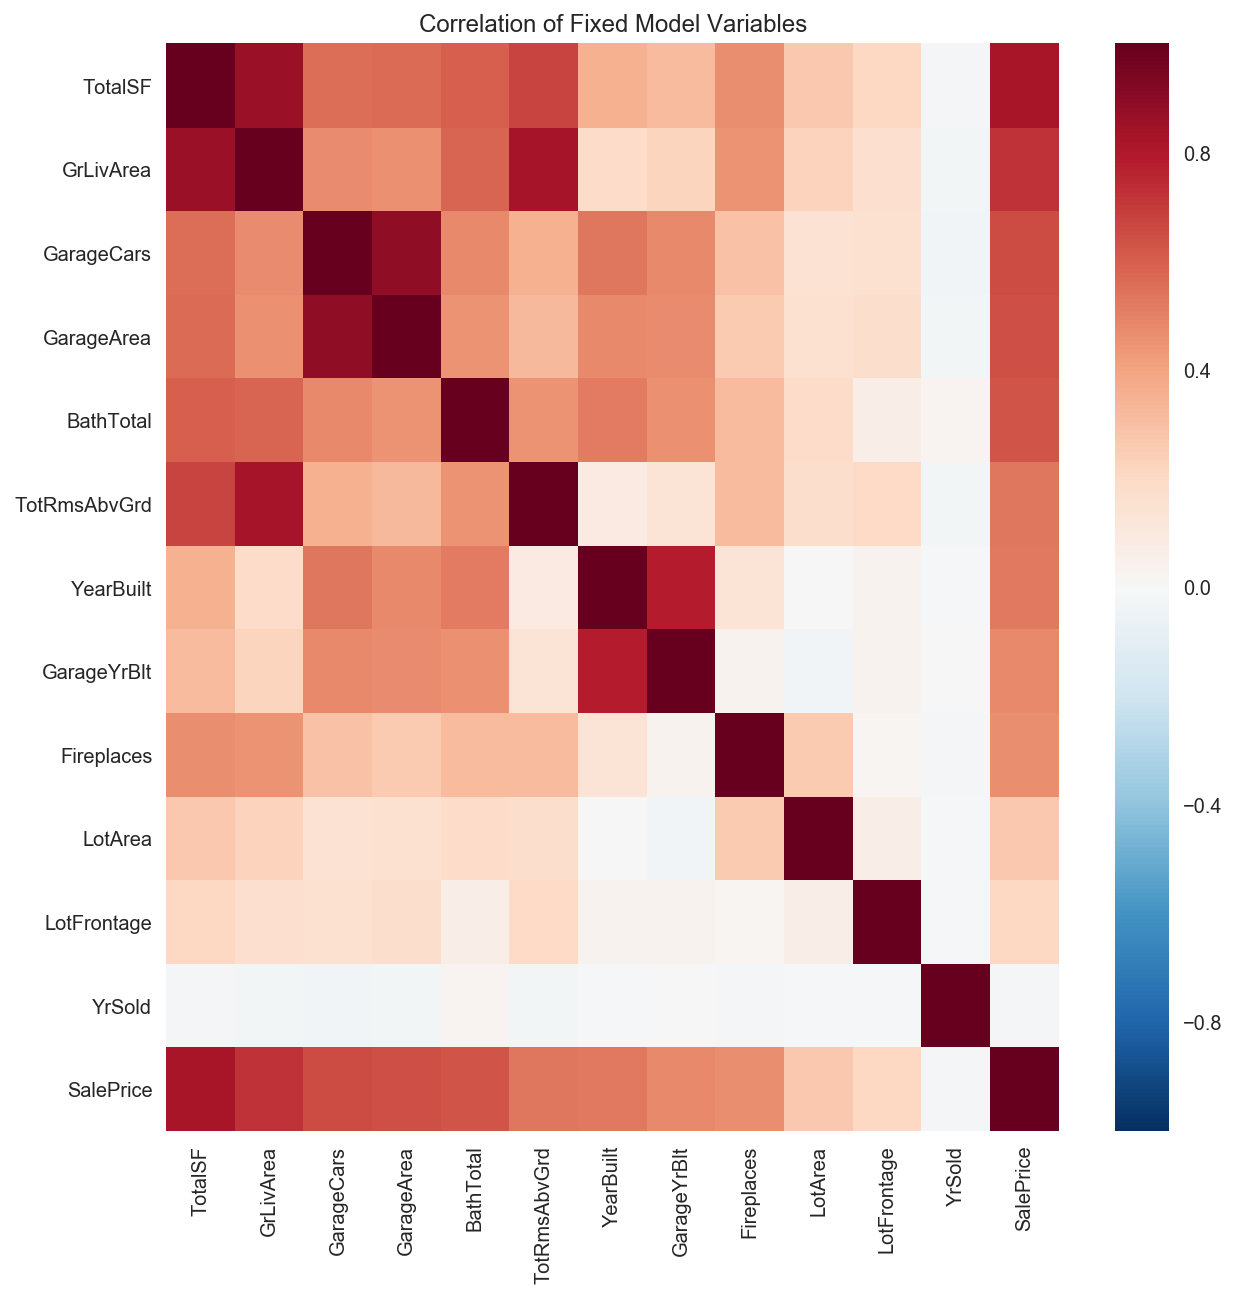

In [316]:
# Fixed Variables correlation matrix (YrSold only included to create train/test data later on)
fixed_variables = house[['TotalSF','GrLivArea','GarageCars','GarageArea','BathTotal',\
                         'TotRmsAbvGrd','YearBuilt','GarageYrBlt','Fireplaces','LotArea','LotFrontage','YrSold','SalePrice']]
fixed_corr = fixed_variables.corr()

#Plot correlation matirx
plt.figure(figsize=[10,10])
sns.heatmap(fixed_corr, 
            xticklabels=fixed_corr.columns.values,
            yticklabels=fixed_corr.columns.values)
plt.title("Correlation of Fixed Model Variables")
plt.show()

In [317]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.cross_validation import cross_val_score

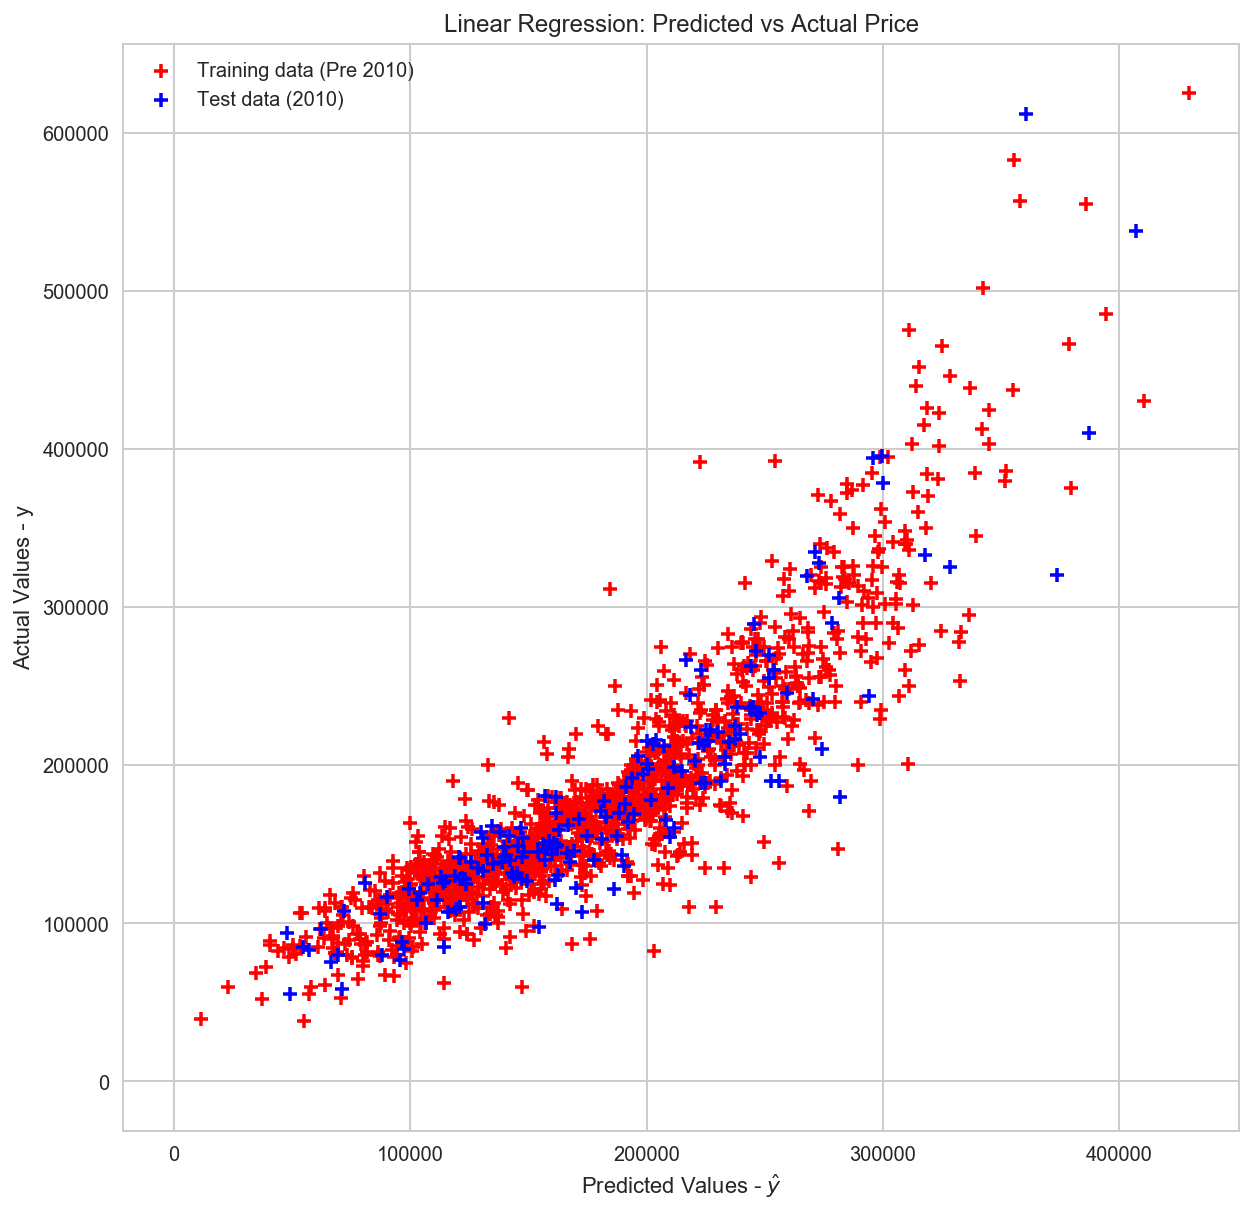

train score:  0.787690627815
test score:  0.791300617264
[ 32319.48558176  15279.44724986   3903.74328034   8002.05653008
   4188.2643381   -5743.14522729  12733.59555641   5553.18929368
   7449.82052912   4231.88803815   4186.94436457]
181113.180534


In [318]:
# Create train dataset from pre-2010 house sales and test data for 2010 sales

fixed_variables_train = fixed_variables[fixed_variables["YrSold"] < 2010]
fixed_variables_test = fixed_variables[fixed_variables["YrSold"] == 2010]

y_train = fixed_variables_train['SalePrice']
X_train = fixed_variables_train.iloc[:,:-2]
y_test = fixed_variables_test['SalePrice']
X_test = fixed_variables_test.iloc[:,:-2]

# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize train and test Xs
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

# Note: Standardization is necessary for regularized regression because the beta values for each predictor variable 
# must be on the same scale. If betas are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less important based on their size.

# Perform Linear Regression on train/test data samples

lr = LinearRegression()

# Fit with training data
lr.fit(Xs_train, y_train)

# Create predicted y values from training
yhat_train = lr.predict(Xs_train)
# Create predicted y values from training
yhat_test = lr.predict(Xs_test)
# Calculate scores for train and test sets
score_train = lr.score(Xs_train, y_train)
score_test = lr.score(Xs_test, y_test)

# Plot model predictions
plt.figure(figsize=(10,10))
plt.scatter(yhat_train, y_train, c = "red", marker = "+", label = "Training data (Pre 2010)")
plt.scatter(yhat_test, y_test, c = "blue", marker = "+", label = "Test data (2010)")
plt.title("Linear Regression: Predicted vs Actual Price")
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

print ("train score: ", score_train)
print ("test score: ", score_test)
print (lr.coef_)
print (lr.intercept_)

## Model Engineering:

I will now perform lasso and ridge penalty analysis to see if I can improve the model.

In [319]:
# Ridge Regression
# select the best alpha with RidgeCV

# create an array of alpha values
alpha_range = 10.**np.arange(-2, 10)

from sklearn.linear_model import RidgeCV

# Ridge regression:
ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='mean_squared_error')
ridgeregcv.fit(Xs_train, y_train)
print (ridgeregcv.alpha_)

print ("ridge score:",ridgeregcv.score(Xs_test, y_test))

0.01
ridge score: 0.791320081752


/Users/tomcroshaw/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/tomcroshaw/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/tomcroshaw/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/tomcroshaw/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

In [320]:
# select the best alpha with LassoCV
from sklearn.linear_model import LassoCV

lassoregcv = LassoCV(normalize=True, random_state=1)
lassoregcv.fit(Xs_train, y_train)

# RMSE
print ("lasso score:",lassoregcv.score(Xs_test, y_test))

lasso score: 0.794030100937


        abs_coef          coef      variable
0   33449.797833  33449.797833       TotalSF
6   12551.179235  12551.179235     YearBuilt
1    9849.628578   9849.628578     GrLivArea
3    8399.914171   8399.914171    GarageArea
8    7212.927268   7212.927268    Fireplaces
7    5050.372160   5050.372160   GarageYrBlt
4    4148.902160   4148.902160     BathTotal
9    3611.601212   3611.601212       LotArea
2    3550.914773   3550.914773    GarageCars
10   3112.612476   3112.612476   LotFrontage
5     680.538343   -680.538343  TotRmsAbvGrd


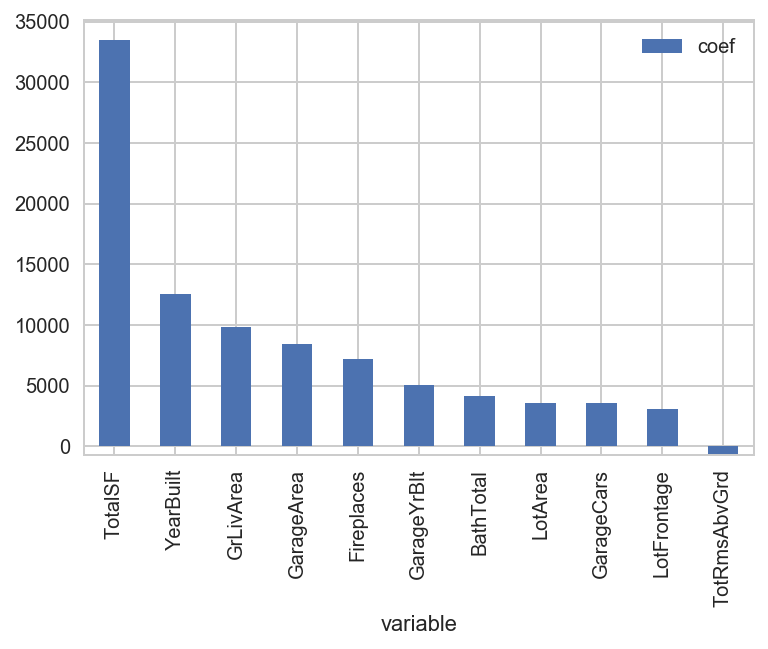

In [321]:
# Examining the coefficients
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lassoregcv.coef_,
                            'abs_coef':np.abs(lassoregcv.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print (lasso_coefs.head(11))

# plot lasso coefficients
lasso_coefs.sort_values('coef',ascending=False).plot(x='variable',y='coef',kind='bar')

My final test will be a MLR using only the predictors where the lasso coefficients are >5000 so see the impact. 
They were not dropped during lasso so they must be valuable predictors, however removing the lower coefficients will allow me to see the overall impact on the model they have...

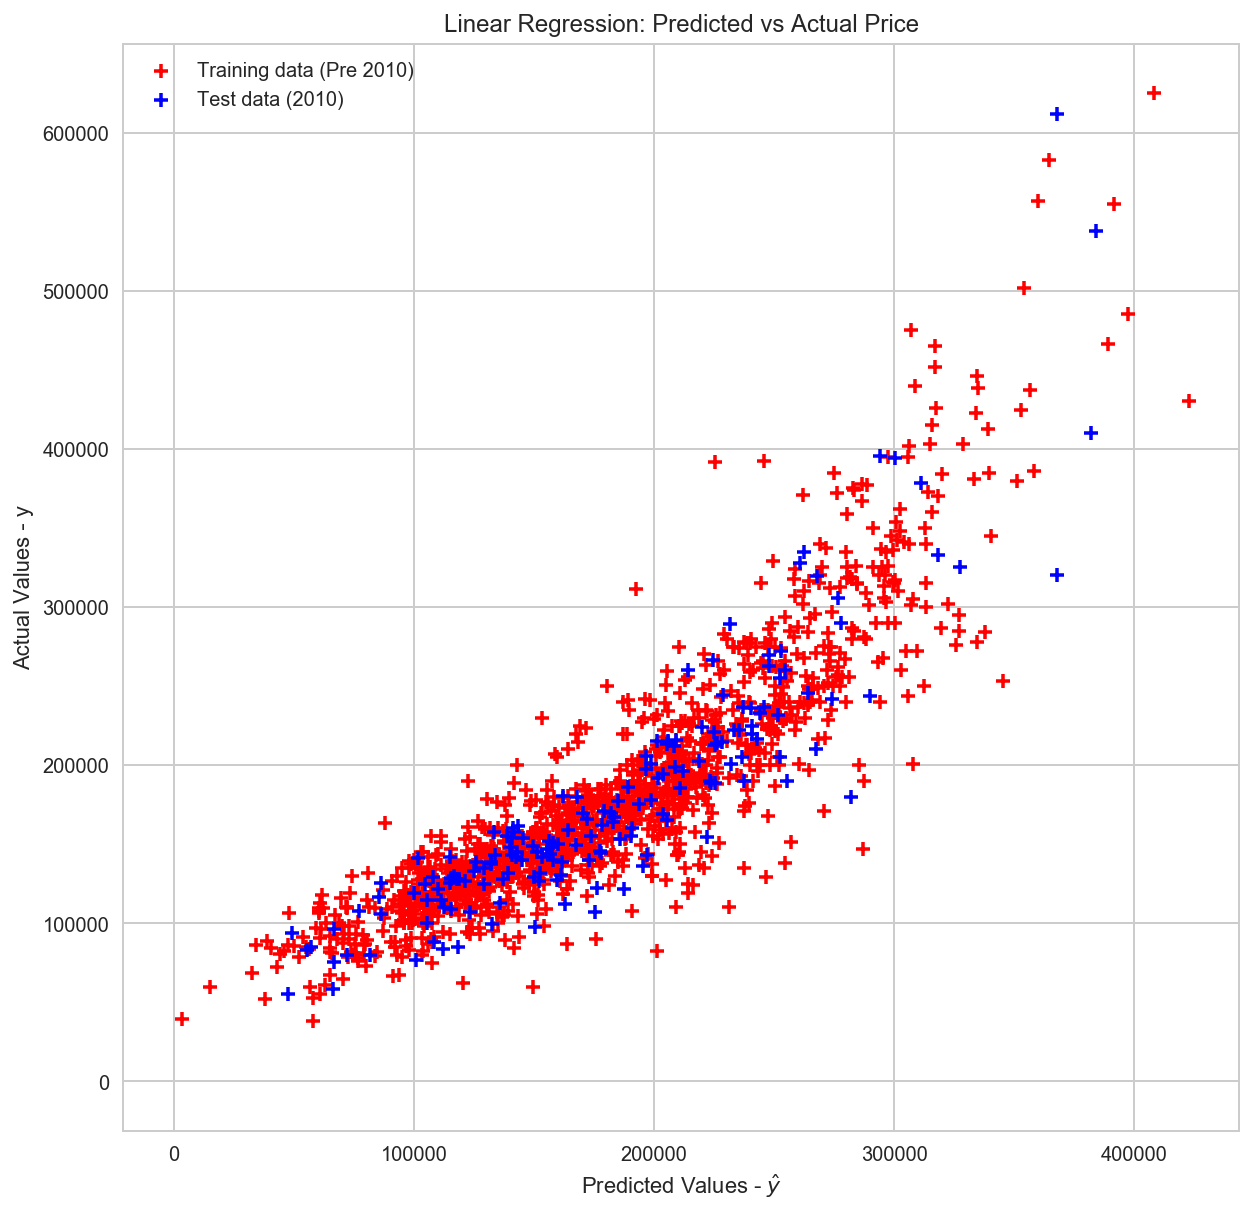

test score:  0.78544195397


In [322]:
# Create train dataset from pre-2010 house sales and test data for 2010 sales

fixed_variables2 = house[['TotalSF','GrLivArea','GarageArea',\
                        'YearBuilt','GarageYrBlt','Fireplaces','SalePrice','YrSold']]

fixed_variables2_train = fixed_variables2[fixed_variables2['YrSold'] < 2010]
fixed_variables2_test = fixed_variables2[fixed_variables2['YrSold'] == 2010]

y_train2 = fixed_variables2_train['SalePrice']
X_train2 = fixed_variables2_train.iloc[:,:-2]
y_test2 = fixed_variables2_test['SalePrice']
X_test2 = fixed_variables2_test.iloc[:,:-2]

# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize
Xs_train2 = ss.fit_transform(X_train2)
Xs_test2 = ss.fit_transform(X_test2)

# Perform Linear Regression on train/test data samples

lr = LinearRegression()

lr.fit(Xs_train2, y_train2)

# Plot
yhat_train2 = lr.predict(Xs_train2)
yhat_test2 = lr.predict(Xs_test2)

score = lr.score(Xs_test2, y_test2)

# Plot
yhat2 = lr.predict(Xs_train2)
score2 = lr.score(Xs_test2, y_test2)

# Plot model predictions
plt.figure(figsize=(10,10))
plt.scatter(yhat_train2, y_train, c = "red", marker = "+", label = "Training data (Pre 2010)")
plt.scatter(yhat_test2, y_test, c = "blue", marker = "+", label = "Test data (2010)")
plt.title("Linear Regression: Predicted vs Actual Price")
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


print ("test score: ", score)

#No major improvement so we will keep the original linear regression model

### Fixed Model Conclusion:
#### Characterize your model. How well does it perform? What are the best estimates of price?

The final model is a multiple linear regression that uses the following variables/predictors (with correlation coefficients to SalePrice, the target). They are ranked in terms of their lasso coefficients:
1. TotalSF: 33458.162931
- YearBuilt: 12568.177256
- GrLivArea: 9852
- GarageArea: 8389
- Fireplaces: 7205
- GarageYrBlt: 5034
- BathTotal: 4157
- LotArea: 3610
- GarageCars: 3507
- LotFrontage: 3116
- TotRmsAbvGrd: 677

The total floor area (square foot of all floors) appears to be the best predictor of sale price.

The coefficient of determination of this model for the train/test data (pre/2010 sales) is:

- Train:  0.7876
- Test:  0.7912

This shoes how that the observed outcomes of both the training and testing data are predicted with moderate confidence by this model.


Ridge and Lasso regression were then performed on the training data to see if they improved the R^2 of our linear regression:

- Ridge: 0.7912
- Lasso: 0.7939

There is minor improvement with both although Lasso is greater, which implies the selected variables cannot be significantly penalised (i.e.: their magnitudes cannot be significantly reduced) to improve the model and there is little overfitting.


A final regression was investigated using only the strongest coefficients (>5000) output from the Lasso regression, to see what affect these predictors have on model performance. The R^2 values of this model with the top six predictors (TotalSF, YearBuilt, GrLivArea, GarageArea, Fireplaces, GarageYrBlt) is reduced by less than 0.01 (0.785) so this proves that these predictors are the main fixed features that drive the sale price target; TotalSF being the greatest, followed by living area size and living area (see the Lasso coefficients for more details).


## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Methodology for Changeable (Renovateable) characteristics

1. Calculate the residiual price remaining from the fixed model. This will provide the target variable (continuous values) for the changeable features model.
2. Introduce new variables/predictors so we can investigate individual condition and quality features (External, Heating, etc.) in the EDA (and potentially the model).
3. Investigate if there is a difference in variable correlations for all properties or just those which have a remodel date (i.e.: house["YearRemodAdd"] != house["YearBuilt"])
4. Model the renovateable features and perform Ridge/Lasso regression to reduce overfitting.
5. Discuss the final model and answer the model goals.

### Set target variable - Residual Price

In [323]:
# Get new y values for both training and testing data (i.e.: all rows)

# Recombine train/test predictors from part-1 for new model:

fixed_variables = house[['TotalSF','GrLivArea','GarageCars','GarageArea','BathTotal',\
                         'TotRmsAbvGrd','YearBuilt','GarageYrBlt','Fireplaces','LotArea','LotFrontage']]

# Check data shape
print (fixed_variables.shape)

# Scale the fixed variables/predictors
ss = StandardScaler()
fixed_variables = ss.fit_transform(fixed_variables)

# Fit model with highest R^2 (Lasso Regression) with original training data and fit predicted y values 
# for full dataset
lassoregcv.fit(Xs_train, y_train)
y_hat = lassoregcv.predict(fixed_variables)

# Calculate the residual sale price using predicted fixed model price

house['Price_Residual'] = (house['SalePrice'] - y_hat).astype(float)
print (house['Price_Residual'].head())

(1446, 11)
0     1128.637381
1    -3170.211731
2    -6103.020248
3   -37661.143786
4   -30458.485593
Name: Price_Residual, dtype: float64


### Feature Engineering

As there are few numeric (continuous, discrete etc.) changeable features, I will now engineer some other potential predictors:

In [324]:
# Convert existing quality and condition predictors to 6 tier ranking:

# Set Qual/Cond dictionary
qual_dict = {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

# Create new value features from existing quality/condition variables:
house['ExterQualVal'] = house['ExterQual'].map(qual_dict).astype(float)
house['ExterCondVal'] = house['ExterCond'].map(qual_dict).astype(float)
house['BsmtQualVal'] = house['BsmtQual'].map(qual_dict).astype(float)
house['BsmtCondVal'] = house['BsmtCond'].map(qual_dict).astype(float)
house['HeatingQClVal'] = house['HeatingQC'].map(qual_dict).astype(float)
house['KitchenQualVal'] = house['KitchenQual'].map(qual_dict).astype(float)
house['FireplaceQuVal'] = house['FireplaceQu'].map(qual_dict).astype(float)
house['GarageQualVal'] = house['GarageQual'].map(qual_dict).astype(float)
house['GarageCondVal'] = house['GarageCond'].map(qual_dict).astype(float)
house['PoolQCVal'] = house["PoolQC"].map(qual_dict).astype(float)

# Convert air conditioning values into 2 tier ranking
air_dict = {"N": 0, "Y": 1}
house['AirConVal'] = house['CentralAir'].map(air_dict).astype(float)

# Check new variables in data.head()
print (house.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave    NA      Reg   
1   2          20       RL         80.0     9600   Pave    NA      Reg   
2   3          60       RL         68.0    11250   Pave    NA      IR1   
3   4          70       RL         60.0     9550   Pave    NA      IR1   
4   5          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities    ...     ExterCondVal BsmtQualVal BsmtCondVal  \
0         Lvl    AllPub    ...              3.0         4.0         3.0   
1         Lvl    AllPub    ...              3.0         4.0         3.0   
2         Lvl    AllPub    ...              3.0         4.0         3.0   
3         Lvl    AllPub    ...              3.0         3.0         4.0   
4         Lvl    AllPub    ...              3.0         4.0         3.0   

  HeatingQClVal KitchenQualVal FireplaceQuVal GarageQualVal  GarageCondVal  \
0           5.0           

In [325]:
# Convert BmstFinType1 factors to 5 tier ranking using descriptions from data dictionary:

basement_dict ={"GLQ": 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2,'Unf': 1, 'NA': 0}
house['BsmtFinType1Val'] = house['BsmtFinType1'].map(basement_dict).astype(float)

print(house.groupby(['BsmtFinType1Val'])['BsmtFinType1Val'].count())

BsmtFinType1Val
0.0     37
1.0    424
2.0     74
3.0    130
4.0    147
5.0    220
6.0    414
Name: BsmtFinType1Val, dtype: int64


Price_Residual    1.000000
KitchenQualVal    0.311061
OverallQual       0.304551
ExterQualVal      0.303752
OverallCond       0.247246
BsmtFinSF1        0.189745
HeatingQClVal     0.175777
MasVnrArea        0.163187
BsmtQualVal       0.152441
OpenPorchSF       0.089226
WoodDeckSF        0.087374
FireplaceQuVal    0.087045
ExterCondVal      0.065133
AirConVal         0.026719
BsmtCondVal       0.008436
PoolQCVal        -0.003716
GarageQualVal    -0.023463
GarageCondVal    -0.031811
Name: Price_Residual, dtype: float64


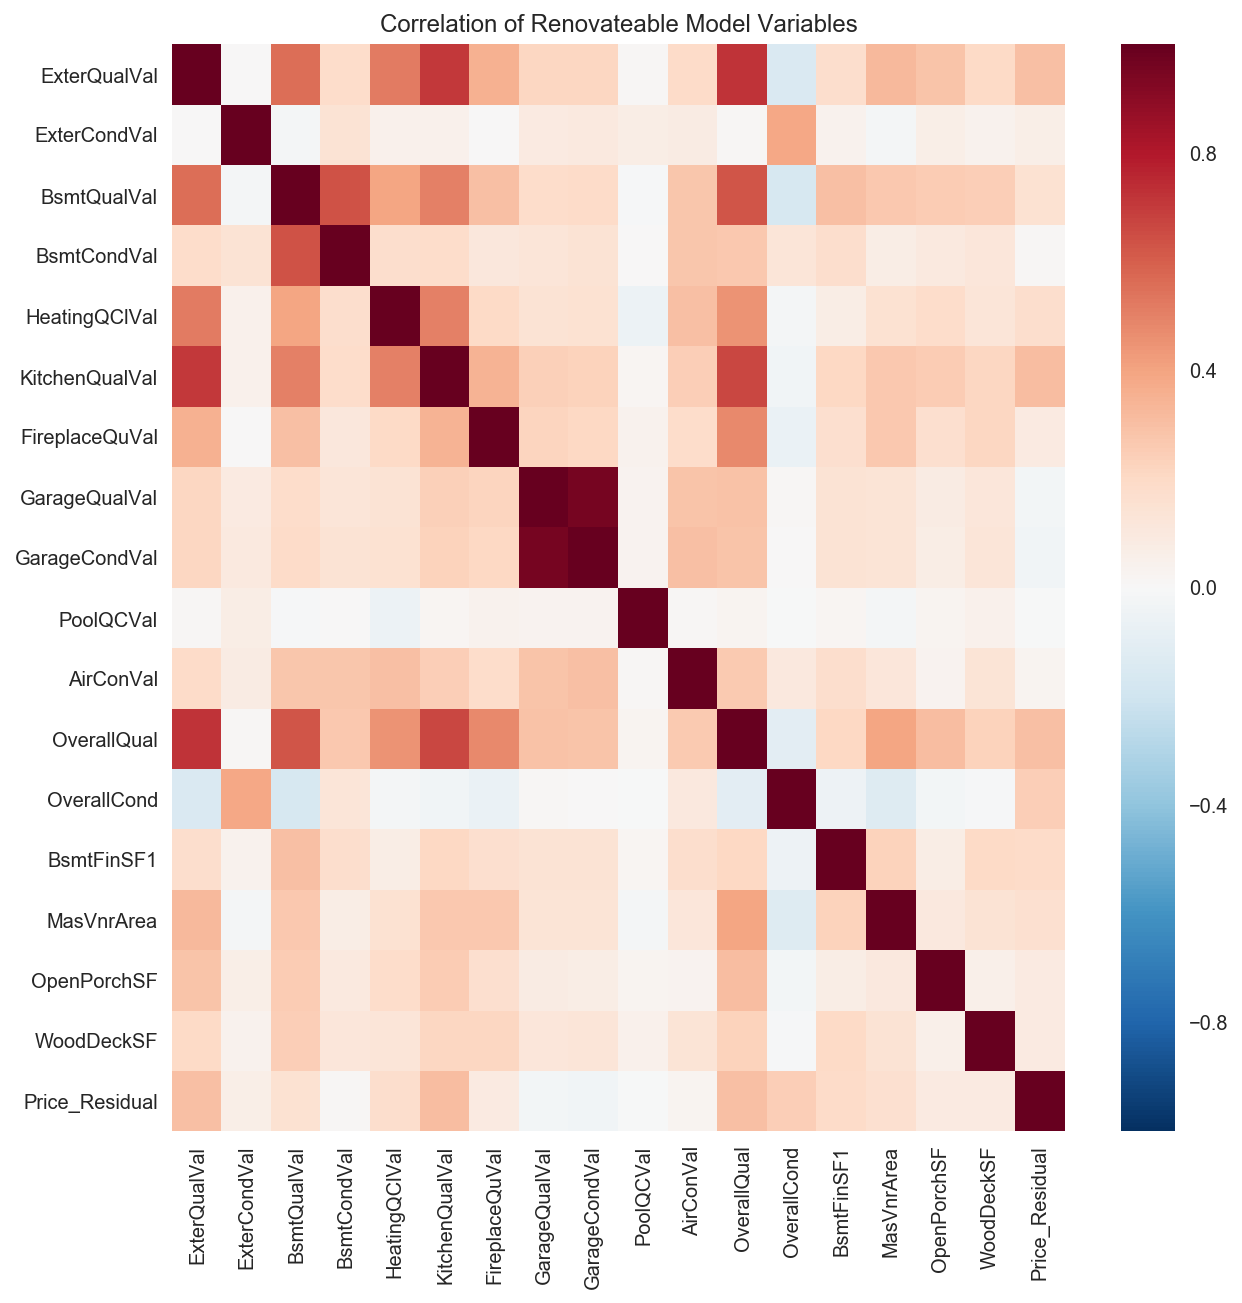

In [326]:
# Create predictor variables from changeable (reno!) features:

reno_variables = house[['ExterQualVal','ExterCondVal','BsmtQualVal','BsmtCondVal','HeatingQClVal',\
                       'KitchenQualVal','FireplaceQuVal','GarageQualVal','GarageCondVal','PoolQCVal',\
                       'AirConVal','OverallQual','OverallCond','BsmtFinSF1','MasVnrArea',\
                       'OpenPorchSF','WoodDeckSF','Price_Residual']]

# Review correlation of changeable variables:

reno_corr = reno_variables.corr()
print (reno_corr['Price_Residual'].sort_values(ascending=False))

# Correlation plot
plt.figure(figsize=[10,10])
sns.heatmap(reno_corr, 
            xticklabels=reno_variables.columns.values,
            yticklabels=reno_variables.columns.values)
plt.title("Correlation of Renovateable Model Variables")
plt.show()

-------
### YearModelAdd Test:

A mini-analysis of the effective of using only properites with registered remodelling...

(1446, 103)
Price_Residual    1.000000
OverallQual       0.326581
KitchenQualVal    0.289507
ExterQualVal      0.281162
MasVnrArea        0.238222
OverallCond       0.232497
BsmtFinSF1        0.216394
BsmtFinSF1        0.216394
BsmtQualVal       0.158962
HeatingQClVal     0.143672
FireplaceQuVal    0.098894
ExterCondVal      0.087535
OpenPorchSF       0.083822
WoodDeckSF        0.078222
AirConVal         0.057288
BsmtCondVal       0.013558
GarageQualVal    -0.009832
GarageCondVal    -0.019290
PoolQCVal        -0.053524
Name: Price_Residual, dtype: float64


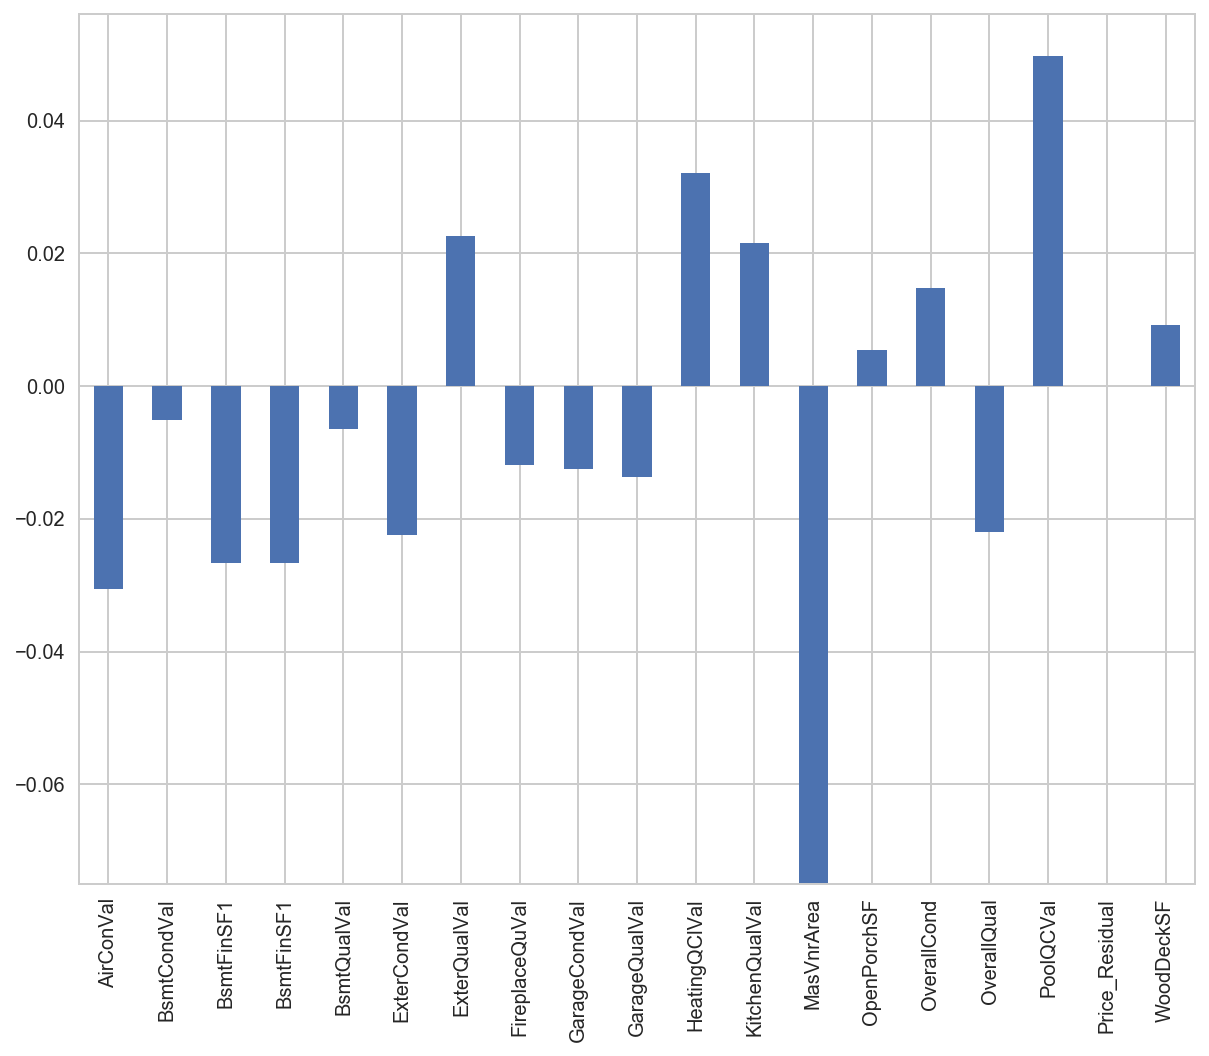

In [327]:
# This is a Test on whether the YearModelAdd has changes the correlation of the renovateable features

# Extracting only those houses that are renovated.
house_YrReno = house[house["YearRemodAdd"] != house["YearBuilt"]]
print (house.shape)

yr_reno_var = house_YrReno[['ExterQualVal','ExterCondVal','BsmtQualVal','BsmtCondVal','HeatingQClVal',\
                       'KitchenQualVal','FireplaceQuVal','GarageQualVal','GarageCondVal','PoolQCVal',\
                       'AirConVal','OverallQual','OverallCond','BsmtFinSF1','MasVnrArea','BsmtFinSF1',\
                       'OpenPorchSF','WoodDeckSF','Price_Residual']]

yr_reno_corr = yr_reno_var.corr()
print (yr_reno_corr['Price_Residual'].sort_values(ascending=False))

# Plot the difference in coefficients
reno_corr_diff = (reno_corr['Price_Residual']) - (yr_reno_corr['Price_Residual'])
plt.figure(figsize=(10,8))
reno_corr_diff.plot(kind='bar')
plt.show()

#### Result:

There is no signifcant, consistent correlation improvement across changeable variables using only properties that have remodelled dates, i.e.: have registered remodelling, so we will not filter the data by this condition to train the model.

------

## Feature Selection

Investigate which features to use in the final model using Recursive Feature Selection and Lasso coefficients.

In [328]:
# Recursive Feature Elimination (RFE) Test

from sklearn.feature_selection import RFECV

X_reno = reno_variables.ix[:,:-1]
y_reno = reno_variables['Price_Residual']

#standardise the renovatable variables
Xs_reno = ss.fit_transform(X_reno)

RFECV_selector = RFECV(lr, step=1, cv=10, verbose=False)
RFECV_selector = RFECV_selector.fit(Xs_reno, y_reno)
score = RFECV_selector.score(Xs_reno, y_reno)

print (X_reno.columns)
print (RFECV_selector.support_)
print (RFECV_selector.ranking_)
print ('RFECV_selector:', score)

Index(['ExterQualVal', 'ExterCondVal', 'BsmtQualVal', 'BsmtCondVal',
       'HeatingQClVal', 'KitchenQualVal', 'FireplaceQuVal', 'GarageQualVal',
       'GarageCondVal', 'PoolQCVal', 'AirConVal', 'OverallQual', 'OverallCond',
       'BsmtFinSF1', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF'],
      dtype='object')
[ True  True  True  True False  True  True  True  True False  True  True
  True  True  True  True False]
[1 1 1 1 2 1 1 1 1 4 1 1 1 1 1 1 3]
RFECV_selector: 0.272212248808


In [329]:
# Lasso regression coefficient test

lassoregcv_reno = LassoCV(normalize=True, random_state=1)
lassoregcv_reno.fit(Xs_reno, y_reno)

# RMSE
print ('Lasso:',lassoregcv_reno.score(Xs_reno, y_reno))
print ('Lasso Reg Shape:', Xs_reno.shape)

Lasso: 0.268921420027
Lasso Reg Shape: (1446, 17)


        abs_coef          coef        variable
12  11474.118167  11474.118167     OverallCond
11   7132.270312   7132.270312     OverallQual
0    5559.200648   5559.200648    ExterQualVal
13   5222.475007   5222.475007      BsmtFinSF1
3    3889.061917  -3889.061917     BsmtCondVal
5    3597.133610   3597.133610  KitchenQualVal
8    2864.219713  -2864.219713   GarageCondVal
6    1985.255878  -1985.255878  FireplaceQuVal
10   1963.086743  -1963.086743       AirConVal
14   1594.373859   1594.373859      MasVnrArea
7    1229.117279  -1229.117279   GarageQualVal


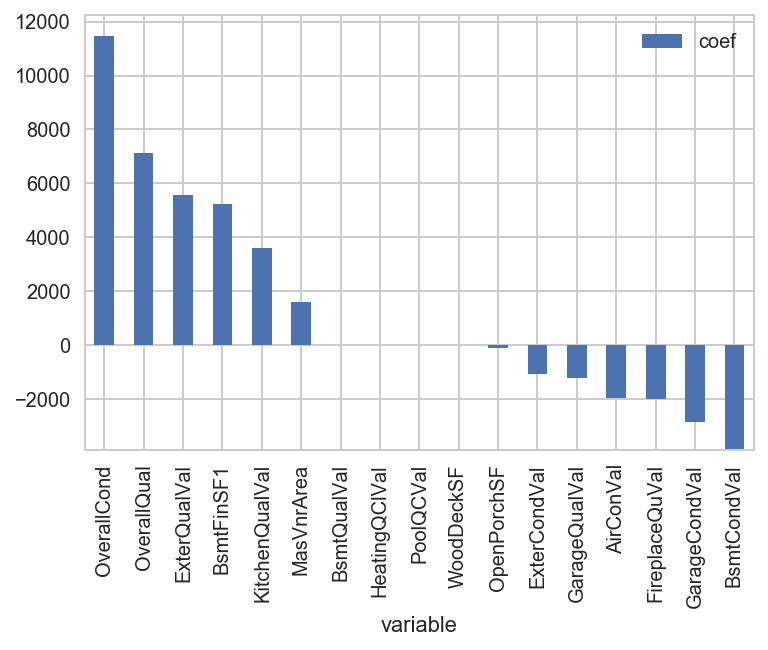

In [330]:
# Examining the lasso coefficients:

lasso_coefs = pd.DataFrame({'variable':X_reno.columns,
                            'coef':lassoregcv_reno.coef_,
                            'abs_coef':np.abs(lassoregcv_reno.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print (lasso_coefs.head(11))

# plot lasso coefficients
plt.figure(figsize=(10,10))
lasso_coefs.sort_values('coef',ascending=False).plot(x='variable',y='coef',kind='bar')
plt.show()

#### Feature Selection Result:

The two feature selection methods provided the following R^2 results:

- RFECV: 0.2725
- Lasso: 0.2692
    
While the RFECV is slightly larger, they both drop the same 3 columns from the model. Therefore I will use the 15 selected features in the renovateable linear regression model.

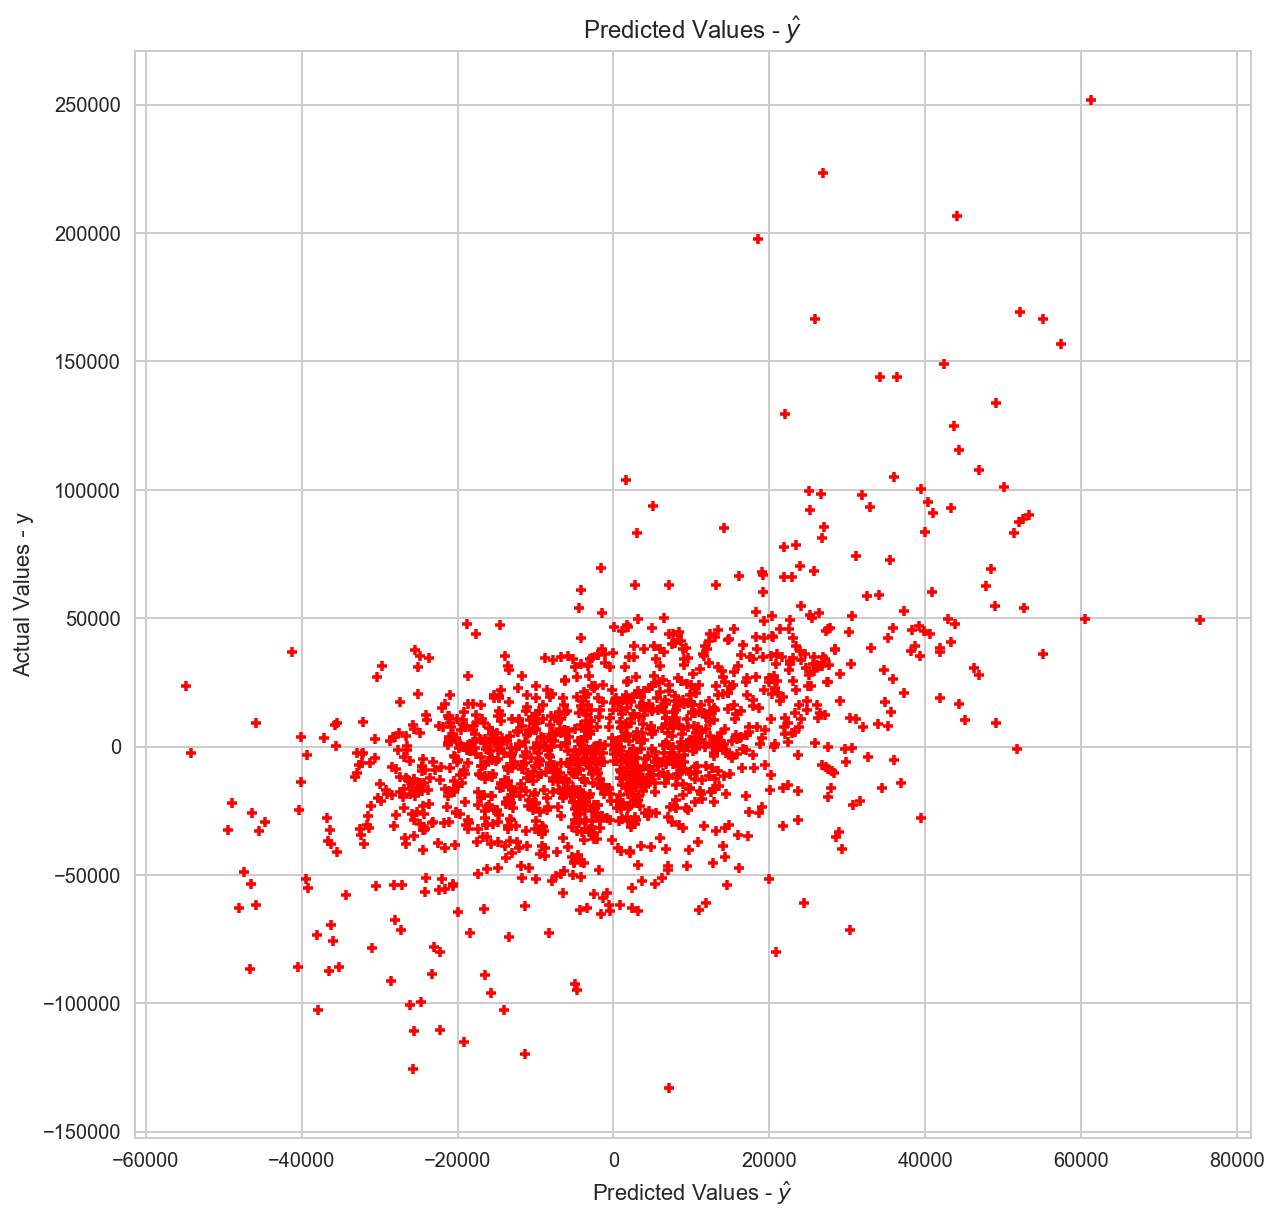

Score:  0.272226587918
Coefficients: [  5656.79313682  -1715.30571295   1191.78394829  -5164.36097925
    165.99672572   3718.17423429  -2882.37090729  -1620.12098142
  -2926.98687473  -2588.63596212   7822.40845241  12733.3073132
   5751.74957153   1969.78845298   -850.12457694]
Intercept: -231.495886449
Changeable MLR coefficients:              0             1            2            3              4   \
0  ExterQualVal  ExterCondVal  BsmtQualVal  BsmtCondVal  HeatingQClVal   
1       5656.79      -1715.31      1191.78     -5164.36        165.997   

               5               6              7              8          9   \
0  KitchenQualVal  FireplaceQuVal  GarageQualVal  GarageCondVal  AirConVal   
1         3718.17        -2882.37       -1620.12       -2926.99   -2588.64   

            10           11          12          13           14  
0  OverallQual  OverallCond  BsmtFinSF1  MasVnrArea  OpenPorchSF  
1      7822.41      12733.3     5751.75     1969.79     -850.125  


In [331]:
# Changeable feature MLR model

# Set final variables to use in MLR and scale

X_reno_final = reno_variables[['ExterQualVal', 'ExterCondVal', 'BsmtQualVal', 'BsmtCondVal',
       'HeatingQClVal', 'KitchenQualVal', 'FireplaceQuVal', 'GarageQualVal',
       'GarageCondVal', 'AirConVal', 'OverallQual', 'OverallCond',
       'BsmtFinSF1', 'MasVnrArea', 'OpenPorchSF']]

ss = StandardScaler()
Xs_reno_final = ss.fit_transform(X_reno_final)

# Perform Linear Regression on train/test data samples

lr = LinearRegression()
lr.fit(Xs_reno_final, y_reno)

# Predict y-values of changeable model
yhat_reno = lr.predict(Xs_reno_final)

# Score of changeable model
score = lr.score(Xs_reno_final, y_reno)

# Plot the model predictions
plt.figure(figsize=(10,10))
plt.scatter(yhat_reno, y_reno, s=30, c='r', marker='+', zorder=10)
plt.title("Predicted Values - $\hat{y}$")
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.show()

print ("Score: ", score)
print ("Coefficients:",lr.coef_)
print ("Intercept:",lr.intercept_)

cols = list(X_reno_final.columns)
reno_coef = pd.DataFrame([cols, list(lr.coef_)])

print ("Changeable MLR coefficients:",reno_coef)

## Final Model Discussion:

The final changeable-feature model has an R^2 value of 0.273. This is not a very strong model and it is unlikely to confidently predict the dollar value of renovateable features as a whole. Despite this, the independent predictor coefficients can provide some insight to which features are likely to add the greatest amount of value to the sale price of a property.

#### Evaluate the effect in dollars of the changeable features:

The top-3 features that most signficantly affect the 'changeable' (fixed model residual) price are:

- Overall Condition: An increase of 1 on the overall condition scale would add 12,731 to the sale price.
- Overall Quality: An increase of 1 on the overall quality scale would add 7,826 to the sale price.
- External Quality: An increase of 1 on the external quality scale (from poor to fair, or good to excellent) would add 5659 to the sale price.

#### How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.

This model can help the company highlight the key factors that increase the sale price of a property and those that do not make a significant difference. The company can identify properties in the market that have the greatest potential for development and ultimately, greater sale price, based on the attributes in the model: each new property can be run through the algorithms to predict the current fixed value, the renovatable potential based on the current characteristics (ie. where to add most value!) and what sale price you could get for it.



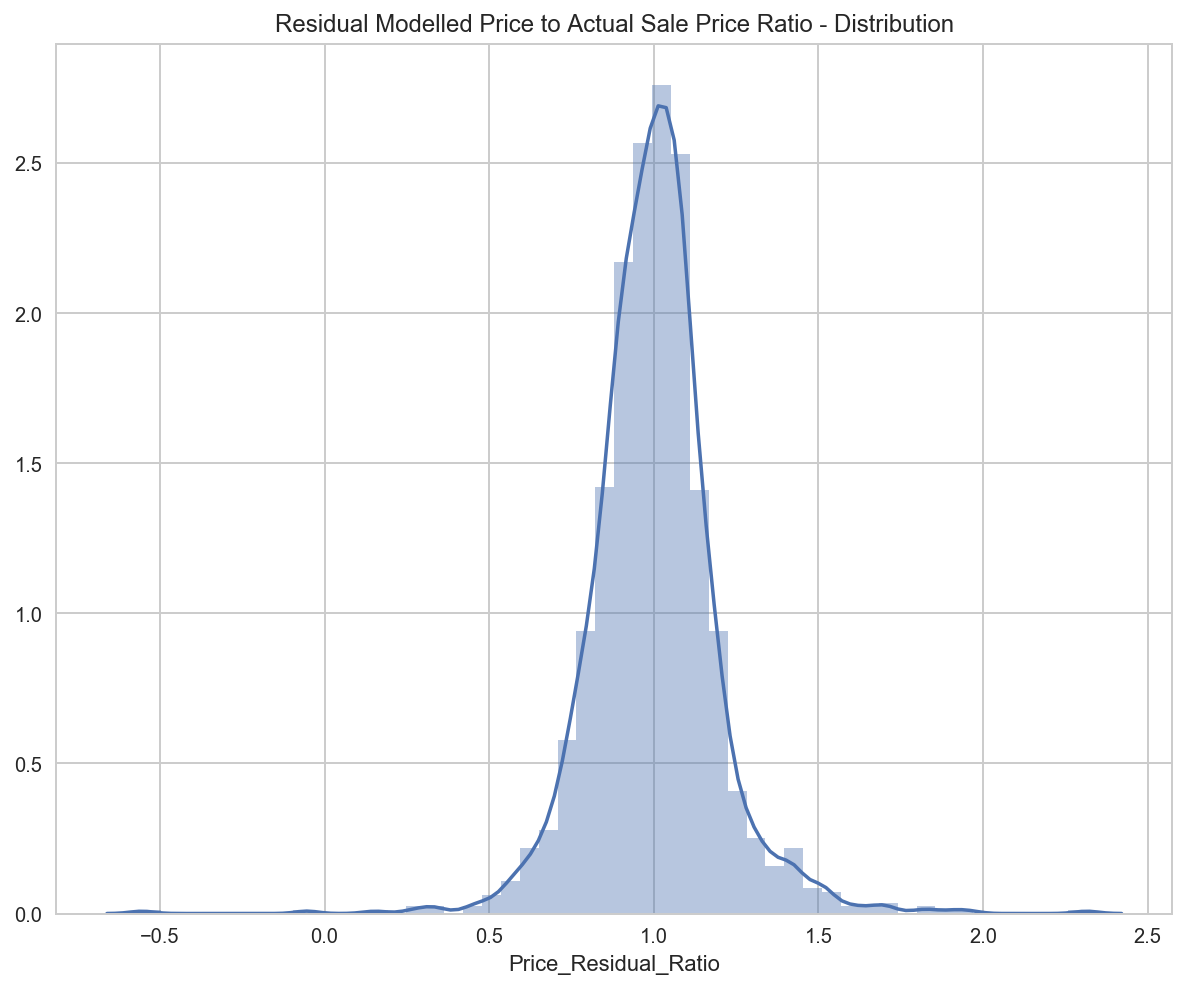

In [332]:
# Investigate how much of the variance in price remaining is explained by these features.

# Calculate the ratio of combined predicted prices (Fixed 'yhat' and changeable 'yhat_reno') to actual price to investigate the variation.

house['Price_Residual_Ratio'] = (y_hat + yhat_reno)/house['SalePrice']

# Plot the Ratio calculations:

plt.figure(figsize=(10,8))
sns.distplot(house['Price_Residual_Ratio'])
plt.title('Residual Modelled Price to Actual Sale Price Ratio - Distribution')
plt.show()

#### Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

I believe with a little further adjustment the fixed price model can be a strong foundation for the SalePrice model. I would definitely add a location component into the model as a project extension.

The changeable features however would need further refinement to improve the model predictability, R^2, and if I were to extend the analysis, I would engineer more features and investigate their impact in greater detail.

However... the visual representation of the price remaining variance (the ratio of total predicted prices of both models, to observed price) shows a strong peak near a 1.0 ratio (i.e.:.the mean ratio is close to 1) proving the majority of SalePrices are actually predicted by the combined model.


## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

## Classification Problem Methodology

1. Firstly I will set the target (Abnormal sales) and potential predictor variables and review the correlation.
- I will then perform a feature selection using chi2, RFE and lasso logistic regression penalisation
- I will use these selections to investigate which features/predictors are the best indicators of abnormals sales by testing multiple logistic regression models.
- (Extenstion) Finally I will test a knn classification model on all the predictors as x to see if th R^2 value improves on the logistic modelling methods

### Target Setting and Predictor Correlation

In [333]:
# Create dummy variables for SaleCondition to extract Abnormal target feature.

# print(house.groupby(['SaleCondition'])['SaleCondition'].count())

house_salecondition = pd.get_dummies(house['SaleCondition'])

# Join the dummy variables to the main dataframe
house = pd.concat([house, house_salecondition], axis=1)

# drop unnecessary columns
house = house.drop('SaleCondition', 1)
house = house.drop('AdjLand', 1)
house = house.drop('Alloca', 1)
house = house.drop('Family', 1)
house = house.drop('Normal', 1)
house = house.drop('Partial', 1)
print (house.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'HeatingQClVal', 'KitchenQualVal', 'FireplaceQuVal', 'GarageQualVal',
       'GarageCondVal', 'PoolQCVal', 'AirConVal', 'BsmtFinType1Val',
       'Price_Residual_Ratio', 'Abnorml'],
      dtype='object', length=104)


In [334]:
# Check amount of Abnormal sales
house.groupby(['Abnorml'])['Abnorml'].count()

Abnorml
0    1351
1      95
Name: Abnorml, dtype: int64

In [335]:
# Extract correlations of each potential predictor to the Abnormal sales type
corr = house.corr()
print (corr['Abnorml'].sort_values(ascending=False))

Abnorml                 1.000000
Price_Residual_Ratio    0.091990
EnclosedPorch           0.068366
BsmtFinSF2              0.053853
KitchenRR               0.053045
PoolQCVal               0.051202
LowQualFinSF            0.049379
BedroomRR               0.049127
BsmtHalfBath            0.042516
ScreenPorch             0.029580
PoolArea                0.024801
LandSlopeVal            0.022592
KitchenAbvGr            0.020291
MSSubClass              0.010555
MoSold                  0.010276
3SsnPorch               0.006536
BsmtCondVal             0.005597
Id                      0.005093
ExterCondVal           -0.000646
Shed                   -0.001382
BedroomAbvGr           -0.001773
TenC                   -0.006976
Gar2                   -0.009869
AirConVal              -0.013389
MiscVal                -0.017433
BsmtFullBath           -0.018710
LotFrontage            -0.018927
OpenPorchSF            -0.022413
BsmtFinType1Val        -0.022916
BsmtFinSF1             -0.023895
          

*Note: All coefficients are very low so we will not exclude any predictors based on this alone.*

## Feature Selection
Investigating which features are likely predictors of abnormal sales through Chi2, RFE and Lasso tests.

In [336]:
# Set up predictor and target

# Take all columns from correlation matrix (i.e. those that numeric)

X = house[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'Gar2', 'Shed',
       'TenC', 'TotalSF', 'YearMax', 'BathTotal', 'KitchenRR', 'BedroomRR',
       'LotShapeVal', 'LandSlopeVal', 'ExterQualVal', 'ExterCondVal',
       'BsmtQualVal', 'BsmtCondVal', 'HeatingQClVal', 'KitchenQualVal',
       'FireplaceQuVal', 'GarageQualVal', 'GarageCondVal', 'PoolQCVal',
       'AirConVal', 'BsmtFinType1Val']]

y = house['Abnorml']

### Chi2 Test

In [337]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

cols = list(X.columns)

# Build the selector (we'll build one with each score type)
skb_chi2 = SelectKBest(chi2, k=5)

# Train the selector on our data
skb_chi2.fit(X, y)

# Txamine results
kbest = pd.DataFrame([cols, list(skb_chi2.scores_)], 
                     index=['feature','chi2_score']).T.sort_values('chi2_score', ascending=False)
print (kbest)

            feature  chi2_score
2           LotArea     9912.41
33          MiscVal     2507.72
9        BsmtFinSF2     2340.95
14     LowQualFinSF      1403.1
29    EnclosedPorch     1160.33
26       GarageArea     1089.98
13         2ndFlrSF     958.696
39          TotalSF     765.957
7        MasVnrArea     549.407
32         PoolArea     541.348
27       WoodDeckSF     494.861
15        GrLivArea     452.445
8        BsmtFinSF1     348.514
10        BsmtUnfSF     319.261
31      ScreenPorch     261.587
11      TotalBsmtSF     223.219
12         1stFlrSF     99.8437
28      OpenPorchSF     65.0942
52   FireplaceQuVal     22.0057
30        3SsnPorch       15.56
55        PoolQCVal     14.4501
1       LotFrontage     10.4152
23       Fireplaces     6.78464
5         YearBuilt     6.04564
0        MSSubClass     5.06852
6      YearRemodAdd     4.81789
40          YearMax     4.81789
25       GarageCars     4.62081
24      GarageYrBlt     4.45743
3       OverallQual     3.54999
53    Ga

### Recursive Feature Elimination

In [338]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
selector = RFECV(logreg, step=1, cv=10,verbose=False)
selector = selector.fit(X, y)

# verbose =  how many times it will conduct the Feature Elimination

# the column names correspond to the one below.  RFECV only excluded a few features.
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Gar2', 'Shed', 'TenC', 'TotalSF', 'YearMax',
       'BathTotal', 'KitchenRR', 'BedroomRR', 'LotShapeVal',
       'LandSlopeVal', 'ExterQualVal', 'ExterCondVal', 'BsmtQualVal',
       'BsmtCondVal', 'HeatingQClVal', 'KitchenQualVal', 'FireplaceQuVal',
       'GarageQualVal', 'GarageCondVal', 'PoolQCVal', 'AirConVal',
       'BsmtFinType1Val'], 
      dtype='<U15')

### Feature elimination using the lasso penalty

In [339]:
# Firstly standardise the predictors
ss = StandardScaler()
Xs = ss.fit_transform(X)

from sklearn.linear_model import LogisticRegressionCV

# Cross Val Logreg and fit with standarised predictors and target
lrcv = LogisticRegressionCV(penalty='l1', Cs=100, cv=10, solver='liblinear') #penalty 11 = lasso
lrcv.fit(Xs, y)

LogisticRegressionCV(Cs=100, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [340]:
# Extract the best coefficients using lasso
coeffs = pd.DataFrame(lrcv.coef_, columns=X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)
print (coeffs_abs)

                 lasso_coefs
KitchenQualVal      0.431003
FireplaceQuVal      0.273745
GarageQualVal       0.250793
GarageYrBlt         0.240421
YearRemodAdd        0.224535
OverallCond         0.224477
ExterQualVal        0.191691
AirConVal           0.166447
1stFlrSF            0.160350
Fireplaces          0.148340
PoolQCVal           0.137204
LotArea             0.136172
BsmtCondVal         0.134696
GrLivArea           0.133852
YearMax             0.130907
BathTotal           0.122190
ScreenPorch         0.116280
BsmtFinSF2          0.103808
MiscVal             0.100455
YrSold              0.097440
BsmtHalfBath        0.077779
PoolArea            0.077499
MSSubClass          0.075823
3SsnPorch           0.065923
FullBath            0.065661
TotRmsAbvGrd        0.063496
BsmtQualVal         0.059722
LotFrontage         0.054095
LandSlopeVal        0.052178
OpenPorchSF         0.051717
EnclosedPorch       0.043056
LowQualFinSF        0.030557
HalfBath            0.030397
BsmtUnfSF     

In [341]:
from sklearn.model_selection import cross_val_score

kbest_columns = kbest.feature.values
lasso_columns = coeffs_abs.index[coeffs_t.lasso_coefs != 0]

logreg = LogisticRegression(C=lrcv.C_[0], penalty='l1', solver='liblinear')

# defining a function to test our best features head-to-head

def score(X):
    scores = cross_val_score(logreg, X, y, cv=10)
    return scores.mean(), scores.std()

# list of all our lists of best features being executes in the score function

all_scores = [
    score(X[kbest_columns]),
    score(X[rfecv_columns]),
    score(X[lasso_columns])]

# putting results into a dataframe

print (pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr']))

       mean score  std score
kbest    0.935004   0.003150
rfecv    0.935004   0.003150
lr       0.934314   0.003188


#### Feature Selection Result:

The chi2 mean R^2 and RFE scores are highest, with Lasso method very close behind. However... all three have very strong feature selections and I will therefore investigate features selected using both ch2 and lasso methods in the logistic regression models that follow: 

### Logisitc Regression Model Testing

In [342]:
import statsmodels.formula.api as sm

# Create a dataframe that only includes the numeric columns (i.e.: those that are output in the correlation)
XY = house[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'Gar2', 'Shed',
       'TenC', 'TotalSF', 'YearMax', 'BathTotal', 'KitchenRR', 'BedroomRR',
       'LotShapeVal', 'LandSlopeVal', 'ExterQualVal', 'ExterCondVal',
       'BsmtQualVal', 'BsmtCondVal', 'HeatingQClVal', 'KitchenQualVal',
       'FireplaceQuVal', 'GarageQualVal', 'GarageCondVal', 'PoolQCVal',
       'AirConVal', 'BsmtFinType1Val','Abnorml']]

# Model 1 - Highest chi2 feature: LotArea

model1 = sm.logit('Abnorml ~ LotArea', data = XY).fit()

model1.summary()

Optimization terminated successfully.
         Current function value: 0.241713
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Abnorml   No. Observations:                 1446
Model:                          Logit   Df Residuals:                     1444
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                0.002702
Time:                        16:39:31   Log-Likelihood:                -349.52
converged:                       True   LL-Null:                       -350.46
                                        LLR p-value:                    0.1688
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3908      0.245     -9.747      0.000      -2.872      -1.910
LotArea    -2.683e-05   2.33e-05     -1.150      0.250   -7.26e-05    1.89e-05
==============================================================================
"""

In [343]:
# Model 2 - Highest 2 chi2 features: LotArea + MiscVal

model2 = sm.logit("Abnorml ~ LotArea + MiscVal", data = XY).fit()

model2.summary()

Optimization terminated successfully.
         Current function value: 0.241282
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Abnorml   No. Observations:                 1446
Model:                          Logit   Df Residuals:                     1443
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                0.004476
Time:                        16:39:31   Log-Likelihood:                -348.89
converged:                       True   LL-Null:                       -350.46
                                        LLR p-value:                    0.2083
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3825      0.244     -9.750      0.000      -2.861      -1.904
LotArea    -2.597e-05   2.32e-05     -1.119      0.263   -7.15e-05    1.95e-05
MiscVal       -0.0009      0.001     -0.800      0.424      -0.003       0.001
==============================================================================
"""

In [344]:
# Model 3 - Chi2 values > 500:

model3 = sm.logit("Abnorml ~ LotArea + MiscVal + BsmtFinSF2 + LowQualFinSF +\
                EnclosedPorch + GarageArea + TotalSF + MasVnrArea + PoolArea", data = XY).fit()

model3.summary()

Optimization terminated successfully.
         Current function value: 0.234359
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Abnorml   No. Observations:                 1446
Model:                          Logit   Df Residuals:                     1436
Method:                           MLE   Df Model:                            9
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                 0.03304
Time:                        16:39:31   Log-Likelihood:                -338.88
converged:                       True   LL-Null:                       -350.46
                                        LLR p-value:                  0.005848
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.9038      0.391     -4.868      0.000      -2.670      -1.137
LotArea       -1.355e-05   2.17e-05     -0.624      0.533   -5.61e-05     2.9e-05
MiscVal          -0.0010      0.001     -0.890      0.374      -0.003       0.001
BsmtFinSF2        0.0010      0.001      2.004      0.045     2.3e-05       0.002
LowQualFinSF      0.0020      0.002      1.260      0.208      -0.001       0.005
EnclosedPorch     0.0027      0.001      1.937      0.053   -3.22e-05       0.006
GarageArea       -0.0015      0.001     -2.401      0.016      -0.003      -0.000
TotalSF       -4.633e-05      0.000     -0.245      0.806      -0.000       0.000
MasVnrArea        0.0001      0.001      0.157      0.876      -0.001       0.002
PoolArea          0.0015      0.002      0.687      0.492      -0.003       0.006
=================================================================================
"""

Note: All 3 model tests provide low R^2 results and have no strong betas/coefficients. This implies the chi2 selection method is not providing us with the most predictive variables for our logistic regression model. I will now investigate the predictors with the highest lasso penalty coefficients.

In [345]:
# Model 4 - Top Lasso coefficients model:

model4 = sm.logit('Abnorml ~ KitchenQualVal + FireplaceQuVal + GarageQualVal + GarageYrBlt + YearMax + OverallCond +\
                    ExterQualVal + AirConVal + Fireplaces + PoolQCVal + LotArea + BsmtCondVal + GrLivArea +\
                    BathTotal + ScreenPorch + YearRemodAdd + MiscVal', data = XY).fit()

model4.summary()

Optimization terminated successfully.
         Current function value: 0.218911
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Abnorml   No. Observations:                 1446
Model:                          Logit   Df Residuals:                     1429
Method:                           MLE   Df Model:                           16
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                 0.09678
Time:                        16:39:31   Log-Likelihood:                -316.55
converged:                       True   LL-Null:                       -350.46
                                        LLR p-value:                 2.382e-08
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         61.7967     12.870      4.802      0.000      36.573      87.021
KitchenQualVal     0.8389      0.250      3.353      0.001       0.349       1.329
FireplaceQuVal    -0.1865      0.146     -1.277      0.202      -0.473       0.100
GarageQualVal     -0.3798      0.113     -3.356      0.001      -0.602      -0.158
GarageYrBlt       -0.0120      0.006     -1.855      0.064      -0.025       0.001
YearMax           -0.0076    4.8e+10  -1.57e-13      1.000   -9.41e+10    9.41e+10
OverallCond       -0.2477      0.103     -2.396      0.017      -0.450      -0.045
ExterQualVal      -0.5332      0.313     -1.702      0.089      -1.147       0.081
AirConVal          0.8957      0.221      4.044      0.000       0.462       1.330
Fireplaces        -0.2006      0.405     -0.496      0.620      -0.994       0.593
PoolQCVal          0.5222      0.293      1.783      0.075      -0.052       1.096
LotArea        -1.648e-05   2.45e-05     -0.673      0.501   -6.45e-05    3.15e-05
BsmtCondVal        0.3119      0.241      1.296      0.195      -0.160       0.784
GrLivArea          0.0004      0.000      1.341      0.180      -0.000       0.001
BathTotal         -0.1863      0.194     -0.960      0.337      -0.567       0.194
ScreenPorch        0.0031      0.002      1.787      0.074      -0.000       0.007
YearRemodAdd      -0.0132    4.8e+10  -2.74e-13      1.000   -9.41e+10    9.41e+10
MiscVal           -0.0012      0.001     -1.085      0.278      -0.003       0.001
==================================================================================
"""

In [346]:
# Model 5 - Top Lasso coefficients model (updated):

model5 = sm.logit('Abnorml ~ KitchenQualVal + FireplaceQuVal + GarageQualVal + OverallCond +\
                    ExterQualVal + AirConVal + Fireplaces + PoolQCVal + BsmtCondVal +\
                    BathTotal', data = XY).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.227427
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Abnorml   No. Observations:                 1446
Model:                          Logit   Df Residuals:                     1435
Method:                           MLE   Df Model:                           10
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                 0.06164
Time:                        16:39:31   Log-Likelihood:                -328.86
converged:                       True   LL-Null:                       -350.46
                                        LLR p-value:                 4.566e-06
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2416      1.052      0.230      0.818      -1.820       2.304
KitchenQualVal     0.6014      0.229      2.628      0.009       0.153       1.050
FireplaceQuVal    -0.1178      0.148     -0.796      0.426      -0.408       0.172
GarageQualVal     -0.3024      0.117     -2.584      0.010      -0.532      -0.073
OverallCond       -0.2578      0.102     -2.522      0.012      -0.458      -0.057
ExterQualVal      -0.9614      0.310     -3.100      0.002      -1.569      -0.354
AirConVal          0.4499      0.462      0.973      0.331      -0.456       1.356
Fireplaces        -0.1078      0.413     -0.261      0.794      -0.917       0.701
PoolQCVal          0.6210      0.279      2.226      0.026       0.074       1.168
BsmtCondVal        0.3225      0.232      1.392      0.164      -0.132       0.777
BathTotal         -0.3402      0.169     -2.013      0.044      -0.671      -0.009
==================================================================================
"""

In [347]:
# Odds Ratios of our highest R^2 Model, model 4:

# To calculate the ORs, I will take the exponential of each of the coefficients. 
# This tells you how a 1 unit increase or decrease in a variable affects the odds of being admitted. 

print (np.exp(model4.params).sort_values(ascending=False))

Intercept         6.886166e+26
AirConVal         2.449143e+00
KitchenQualVal    2.313891e+00
PoolQCVal         1.685773e+00
BsmtCondVal       1.365978e+00
ScreenPorch       1.003120e+00
GrLivArea         1.000396e+00
LotArea           9.999835e-01
MiscVal           9.987552e-01
YearMax           9.924761e-01
GarageYrBlt       9.881192e-01
YearRemodAdd      9.869162e-01
BathTotal         8.300610e-01
FireplaceQuVal    8.298749e-01
Fireplaces        8.182523e-01
OverallCond       7.806090e-01
GarageQualVal     6.839715e-01
ExterQualVal      5.867195e-01
dtype: float64


The relative R^2 value of model 5 is not improved on model 4, but is still stronger than features selected using chi2.

Model 4 provides the strongest R^2 yet. This implies the lasso coefficients indicate stronger predictors than the chi2 test. The final model will test the highest coefficients of model 4 to see if the lower coefficients are reducing the strength of the model.

### Classification Discussion:

In the limited time available to investigate the classification for the Abnormal sales indentification model I have drawn the following conclusions.

- The predictors selected during the Chi2 selection method (i.e.: those with the highest chi2 values) yield some of the lowest logisitc regression coefficients that predict the Abnorml classifier (models 1 - 3).
- The predictors that had the highest lasso coefficients generally had higher regression coefficients (see model 4: AirConVal, KitchenQualVa, ExterQualVal) than those identified with the chi2 test. The highest odds ratios was 2.5 for AirConVal (however this is not a continuous value).
- No model that was tested, including analysing only the continuous variables in model 4, yielded R^2 values of any significance. The highest R^2 values was model 4; a model which used high lasso coefficient predictors. I would therefore look at the [high] lasso coefficient predictors further in any extension of this analysis.

Overall there was little evidence to suggest any individual features were independently predictive of producing Abnormal sales. However... Generally the predictors that produced the higher coefficients were "changeable" in nature (Aircon, quality finishes, external veneer), but there is not enough evidence to confirm this... It is certainly a  hypothesis to investigate further.


## Extra Analysis: 
### KNN Classification Test

Is a KNN model a better classification method than logisitc regression? 

I will now test all original predictors against the Abnorml target to see how the R^2 values compare.

In [348]:
baseline = 1. - y.mean()
print (baseline)

0.934301521438


KNN scores [ 0.93103448  0.93425606  0.92733564  0.93079585  0.93079585]
KNN mean scores 0.930843574752


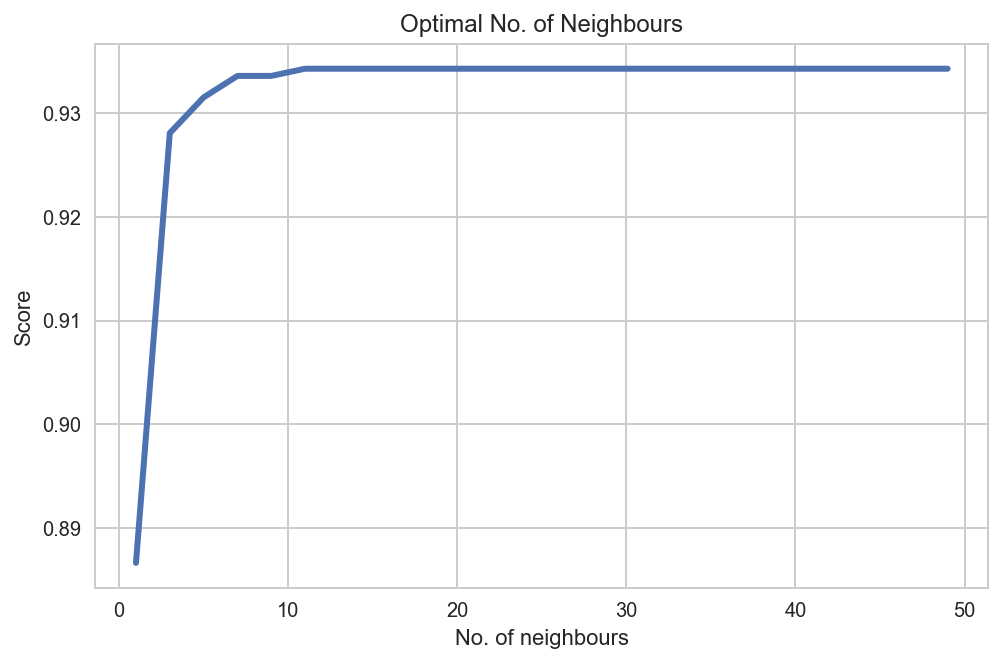

In [349]:
X_model = X[[c for c in X.columns if not c in ['Abnorml']]]
y = house['Abnorml']

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X_model)

# Fit knn model with all predictors

knn = KNeighborsClassifier()
knn.fit(X_model,y)
scores = cross_val_score(knn, Xs, y, cv=5)
print ("KNN scores",scores)
print ("KNN mean scores",np.mean(scores))

# Plot the best knn numbers
k_values = range(1,50,2)
accs = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xs, y, cv=10)
    accs.append(np.mean(scores))

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, accs, lw=3)
plt.title('Optimal No. of Neighbours')
plt.xlabel("No. of neighbours")
plt.ylabel("Score")
plt.show()

The R^2 coefficients for the two original models _(with all possible predictors)_ are:
- Knn: 0.9308 (with optimal nearest neighbours of 11)
- Lasso penalised Logistic Regression: 0.9343
Both classification methods are very similar (only 0.004 difference!) which indicates one classification algorithm does not have significant confidence over another.


Further classification investigation could include:
- KNN feature selection
- Gridsearching for both logistic regression and KNN models...

### End! :)